In [211]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import os
import sys
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
import pyarrow.parquet as pq
from matplotlib.backends.backend_pdf import PdfPages 
from matplotlib.path import Path
from enum import Enum

import gc
gc.collect()

sys.path.append('/groups/icecube/cyan/Utils')
from PlotUtils import setMplParam, getColour, getHistoParam 
from ExternalFunctions import nice_string_output, add_text_to_ax
setMplParam()
sys.path.append('/groups/icecube/cyan/factory/DOMification')
from Enum.Flavour import Flavour
from Enum.EnergyRange import EnergyRange
from EventPeek.PseudoNormaliser import PseudoNormaliser

In [212]:
# root_dir_noCR_CC_IN = "/lustre/hpc/project/icecube/HE_Nu_Aske_Oct2024/PMTfied_filtered_third_round/Snowstorm/CC_CRclean_Contained/"
root_dir = "/lustre/hpc/project/icecube/HE_Nu_Aske_Oct2024/PMTfied_third/Snowstorm/"
er = EnergyRange.ER_10_TEV_1_PEV
flavour = Flavour.MU
dir_TeV_nu_mu_1_1 = os.path.join(root_dir, EnergyRange.get_subdir(er, flavour), "1", "PMTfied_1.parquet")
dir_TeV_nu_mu_1_truth = os.path.join(root_dir, EnergyRange.get_subdir(er, flavour), "truth_1.parquet")

In [213]:
border_xy = np.array(
    [
        (-256.1400146484375, -521.0800170898438),
        (-132.8000030517578, -501.45001220703125),
        (-9.13000011444092, -481.739990234375),
        (114.38999938964844, -461.989990234375),
        (237.77999877929688, -442.4200134277344),
        (361.0, -422.8299865722656),
        (405.8299865722656, -306.3800048828125),
        (443.6000061035156, -194.16000366210938),
        (500.42999267578125, -58.45000076293945),
        (544.0700073242188, 55.88999938964844),
        (576.3699951171875, 170.9199981689453),
        (505.2699890136719, 257.8800048828125),
        (429.760009765625, 351.0199890136719),
        (338.44000244140625, 463.7200012207031),
        (224.5800018310547, 432.3500061035156),
        (101.04000091552734, 412.7900085449219),
        (22.11000061035156, 509.5),
        (-101.05999755859375, 490.2200012207031),
        (-224.08999633789062, 470.8599853515625),
        (-347.8800048828125, 451.5199890136719),
        (-392.3800048828125, 334.239990234375),
        (-437.0400085449219, 217.8000030517578),
        (-481.6000061035156, 101.38999938964844),
        (-526.6300048828125, -15.60000038146973),
        (-570.9000244140625, -125.13999938964844),
        (-492.42999267578125, -230.16000366210938),
        (-413.4599914550781, -327.2699890136719),
        (-334.79998779296875, -424.5),
    ]
)

vertices_xy = np.array(
    [
        (-256.1400146484375, -521.0800170898438),
        (-570.9000244140625, -125.13999938964844),
        (-347.8800048828125, 451.5199890136719), # this guy
        (22.11000061035156, 509.5), # this guy
        (576.3699951171875, 170.9199981689453), # this guy
        (361.0, -422.8299865722656),
    ]
)
auxiliary_vertices_xy = np.array(
    [
        (101.04000091552734, 412.7900085449219),
        (338.44000244140625, 463.7200012207031),
        (269.70961549, 548.30058428),
    ]
    )
imaginary_vertex_xy = np.array([(269.70961549, 548.30058428)])
    
border_z = np.array([-512.82, 524.56])

In [214]:
def define_line(point: np.ndarray, direction: np.ndarray):
    """
    Returns a parametric function of the line: r(t) = point + t * direction
    """
    return lambda t: point + t * direction


In [215]:
def def_line_two_points(point1: np.ndarray, point2:np.ndarray):
    """
    Returns a parametric function of the line: r(t) = point1 + t * (point2 - point1)
    """
    return define_line(point1, point2 - point1)

In [216]:
# def define_plane(point1: np.ndarray, 
#                  point2: np.ndarray, 
#                  point3: np.ndarray):
#     """
#     Returns a function representing the plane equation.
#     The function returns zero for any point lying on the plane.
#     """
#     # Two vectors in the plane
#     v1 = point2 - point1
#     v2 = point3 - point1
#     # Normal vector to the plane
#     normal = np.cross(v1, v2)

#     # Plane equation: (r - p1) • n = 0
#     return lambda r: np.dot(r - point1, normal)


In [ ]:
def define_plane(point1: np.ndarray, 
                 point2: np.ndarray, 
                 point3: np.ndarray):
    """
    Defines a plane equation and its valid rectangular region.
    
    Returns:
        - A function that computes the plane equation value.
        - A function that checks if a point is within the bounded region.
    """
    # Compute normal vector
    v1 = point2 - point1
    v2 = point3 - point1
    normal = np.cross(v1, v2)

    # Plane equation: (r - point1) • normal = 0
    plane_func = lambda r: np.dot(r - point1, normal)

    # Find rectangular bounds (min/max of x, y, z)
    min_x, max_x = min(point1[0], point2[0], point3[0]), max(point1[0], point2[0], point3[0])
    min_y, max_y = min(point1[1], point2[1], point3[1]), max(point1[1], point2[1], point3[1])
    min_z, max_z = min(point1[2], point2[2], point3[2]), max(point1[2], point2[2], point3[2])

    # Function to check if a point is inside the plane boundary
    def is_inside_bounds(point, eps=1e-4):
        return (min_x - eps <= point[0] <= max_x + eps and 
                min_y - eps <= point[1] <= max_y + eps and 
                min_z - eps <= point[2] <= max_z + eps)

    return plane_func, is_inside_bounds


In [218]:
def is_inside_hexagon(point, hexagon_vertices):
    """
    Checks if a point is inside a hexagonal region in the xy-plane.
    
    Args:
        point: (x, y) coordinates of the intersection.
        hexagon_vertices: List of (x, y) points defining the hexagon.
    
    Returns:
        True if inside, False otherwise.
    """
    x, y = point[:2]
    poly = Path(hexagon_vertices)  # Matplotlib Path utility
    return poly.contains_point((x, y))

In [219]:
def intersection_two_lines(line1, line2):
    """
    Returns the intersection point of two lines in 2D (z assumed constant).
    """
    p1 = line1(0)[:2]
    d1 = line1(1)[:2] - p1
    p2 = line2(0)[:2]
    d2 = line2(1)[:2] - p2

    cross = d1[0]*d2[1] - d1[1]*d2[0]
    if np.isclose(cross, 0):
        raise ValueError("Lines are parallel or coincident, no unique intersection.")

    t = ((p2 - p1)[0] * d2[1] - (p2 - p1)[1] * d2[0]) / cross
    intersection = line1(t)
    return intersection


In [220]:
aux_night_line = def_line_two_points(np.array((-347.8800048828125, 451.5199890136719, 0)), np.array((22.11000061035156, 509.5,0)))
aux_morning_line = def_line_two_points(np.array((338.44000244140625, 463.7200012207031,0)), np.array((576.3699951171875, 170.9199981689453,0)))
intersection_two_lines(aux_night_line, aux_morning_line)

array([269.70961549, 548.30058428,   0.        ])

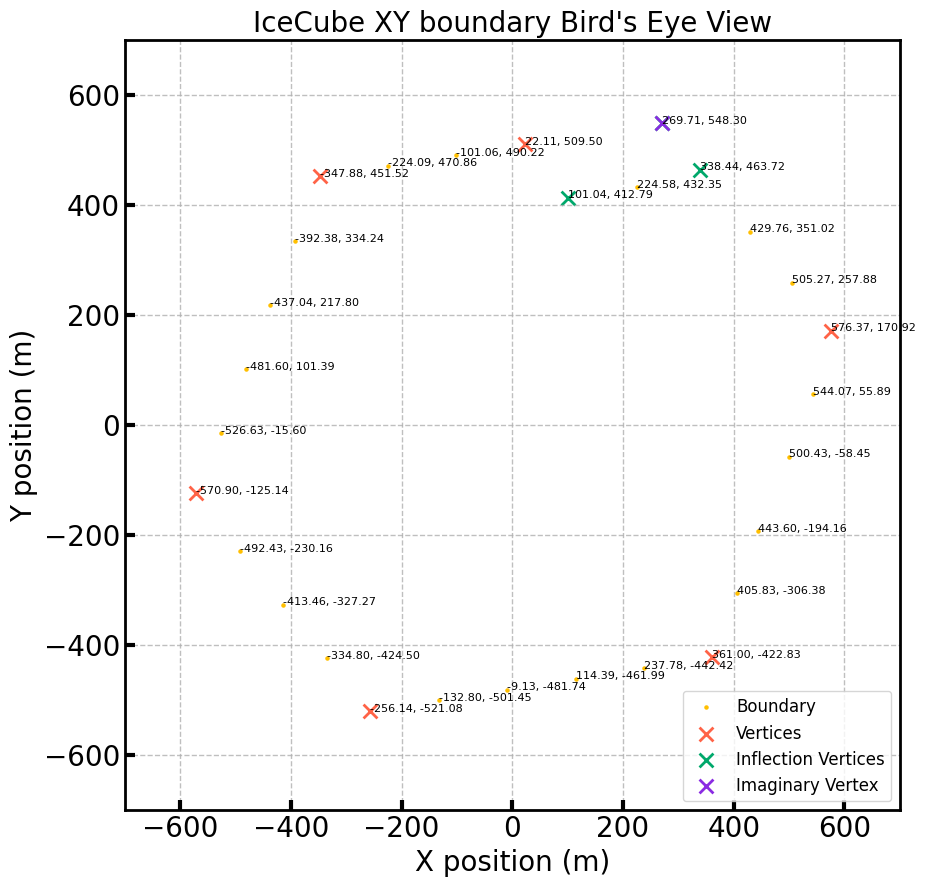

In [221]:
def plot_XY(border_xy, vertices_xy, auxiliary_vertices_xy, imaginary_vertex_xy=None):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.scatter(border_xy[:, 0], border_xy[:, 1], color=getColour(1), marker=".", s=20, label="Boundary")
    ax.scatter(vertices_xy[:, 0], vertices_xy[:, 1], color=getColour(2), marker="x", s=100, label="Vertices")
    ax.scatter(auxiliary_vertices_xy[:, 0], auxiliary_vertices_xy[:, 1], color=getColour(3), marker="x", s=100, label="Inflection Vertices")
    if imaginary_vertex_xy is not None:
        ax.scatter(imaginary_vertex_xy[0, 0], imaginary_vertex_xy[0, 1], color=getColour(4), marker="x", s=100, label="Imaginary Vertex")
    ax.legend(loc="lower right")
    ax.set_xlabel("X position (m)")
    ax.set_ylabel("Y position (m)")
    
    # print values in .2f format next to the points
    for i, (x, y) in enumerate(border_xy):
        ax.text(x, y, f"{x:.2f}, {y:.2f}", fontsize=8)
    ax.text(imaginary_vertex_xy[0, 0], imaginary_vertex_xy[0, 1], f"{imaginary_vertex_xy[0, 0]:.2f}, {imaginary_vertex_xy[0, 1]:.2f}", fontsize=8)
    ax.set_title("IceCube XY boundary Bird's Eye View")
    ax.set_xlim(-700, 700)
    ax.set_ylim(-700, 700)
plot_XY(border_xy, vertices_xy, auxiliary_vertices_xy, imaginary_vertex_xy)

In [222]:
def convertParquetToDF(file:str) -> pd.DataFrame:
    table = pq.read_table(file)
    df = table.to_pandas()
    return df

In [223]:
df_TeV_nu_mu_1_1 = convertParquetToDF(dir_TeV_nu_mu_1_1)
df_TeV_nu_mu_1_truth = convertParquetToDF(dir_TeV_nu_mu_1_truth)

In [224]:
df_TeV_nu_mu_1_1.columns

Index(['event_no', 'original_event_no', 'dom_x', 'dom_y', 'dom_z', 'dom_x_rel',
       'dom_y_rel', 'dom_z_rel', 'pmt_area', 'rde', 'saturation_status',
       'bad_dom_status', 'bright_dom_status', 'q1', 'q2', 'q3', 'q4', 'q5',
       'Q25', 'Q75', 'Qtotal', 'hlc1', 'hlc2', 'hlc3', 'hlc4', 'hlc5', 't1',
       't2', 't3', 't4', 't5', 'T10', 'T50', 'sigmaT', 't_qmax',
       't_qmax_secondhalf', 'Q_halftime', 'T70', 'T90', 'eccentricity_PCA',
       'aspect_contrast_PCA', 'hypotenuse'],
      dtype='object')

In [225]:
df_TeV_nu_mu_1_truth.columns

Index(['event_no', 'original_event_no', 'subdirectory_no', 'part_no',
       'shard_no', 'N_doms', 'offset', 'energy', 'azimuth', 'zenith',
       ...
       'SolidAngle', 'TotalColumnDepthCGS', 'TotalPrimaryWeight',
       'TotalWeight', 'TotalXsectionCGS', 'TrueActiveLengthAfter',
       'TrueActiveLengthBefore', 'TypeWeight', 'max_interPMT_distance',
       'isWithinIceCube'],
      dtype='object', length=129)

In [226]:
df_TeV_nu_mu_1_truth[['pos_x_GNHighestEInIceParticle', 'pos_y_GNHighestEInIceParticle', 'pos_z_GNHighestEInIceParticle']].head()

pos_x_GNHighestEInIceParticle  pos_y_GNHighestEInIceParticle  \
0                     365.169647                     -15.324171   
1                    3147.981934                    4016.567383   
2                      31.484516                     643.407959   
3                    -216.276337                      33.131054   
4                   -1305.044434                    -438.745483   

   pos_z_GNHighestEInIceParticle  
0                    -587.404785  
1                    1950.079956  
2                   -1799.195557  
3                     448.082947  
4                     250.894653

In [227]:
df_TeV_nu_mu_1_truth[['pos_x_GNHighestEInIceParticle', 'pos_y_GNHighestEInIceParticle', 'pos_z_GNHighestEInIceParticle']].describe()

pos_x_GNHighestEInIceParticle  pos_y_GNHighestEInIceParticle  \
count                  400561.000000                  400561.000000   
mean                        3.612428                       2.461256   
std                      2135.992432                    2151.703125   
min                    -23526.972656                  -27702.556641   
25%                      -615.803101                    -611.669434   
50%                        -1.570160                       0.368172   
75%                       621.159058                     608.400757   
max                     24418.697266                   22791.880859   

       pos_z_GNHighestEInIceParticle  
count                  400561.000000  
mean                       35.290806  
std                      1109.159424  
min                     -7558.757324  
25%                      -561.459229  
50%                        71.258698  
75%                       765.399536  
max                      1950.079956

array([[<Axes: title={'center': 'pos_x_GNHighestEInIceParticle'}>,
        <Axes: title={'center': 'pos_y_GNHighestEInIceParticle'}>],
       [<Axes: title={'center': 'pos_z_GNHighestEInIceParticle'}>,
        <Axes: >]], dtype=object)

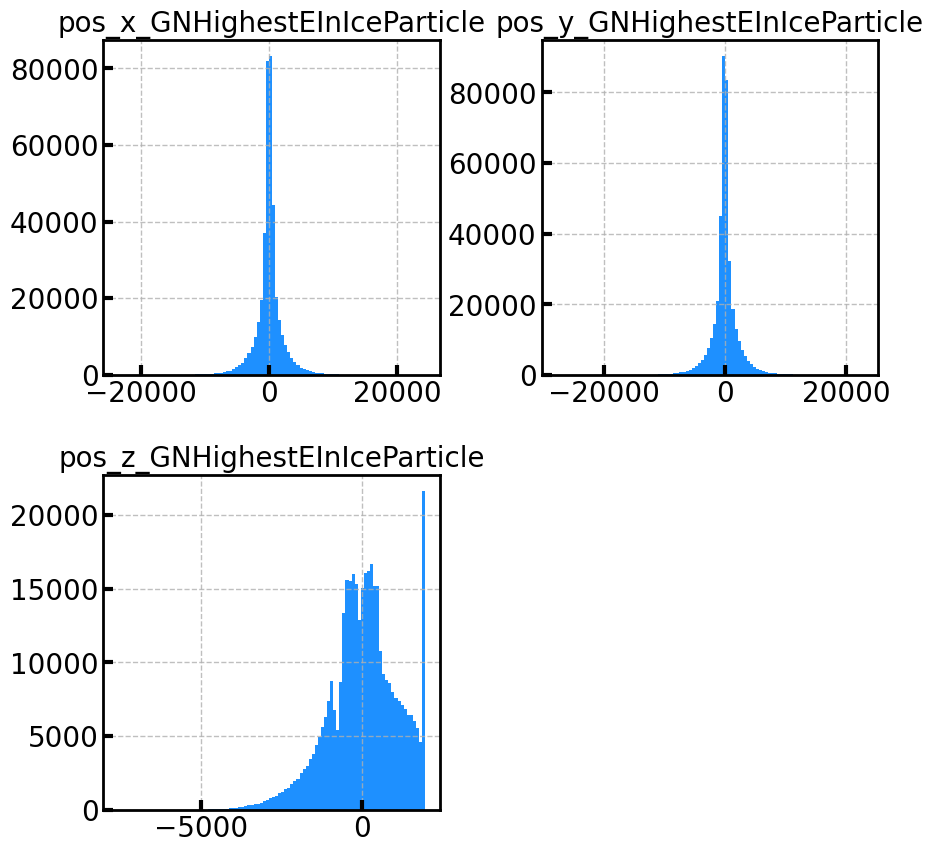

In [228]:
df_TeV_nu_mu_1_truth[['pos_x_GNHighestEInIceParticle', 'pos_y_GNHighestEInIceParticle', 'pos_z_GNHighestEInIceParticle']].hist(bins=100, figsize=(10, 10))

In [229]:
df_TeV_nu_mu_1_truth[['pos_x_GNHighestEDaughter', 'pos_y_GNHighestEDaughter', 'pos_z_GNHighestEDaughter']].head()

pos_x_GNHighestEDaughter  pos_y_GNHighestEDaughter  \
0              3.651696e+02             -1.532417e+01   
1              1.182098e+04             -8.403150e+03   
2             -1.517584e+06              1.267163e+06   
3             -2.162763e+02              3.313105e+01   
4             -1.305044e+03             -4.387455e+02   

   pos_z_GNHighestEDaughter  
0             -5.874048e+02  
1              1.467889e+03  
2             -9.479107e+06  
3              4.480829e+02  
4              2.508947e+02

In [230]:
df_TeV_nu_mu_1_truth[['pos_x_GNHighestEDaughter', 'pos_y_GNHighestEDaughter', 'pos_z_GNHighestEDaughter']].describe()

pos_x_GNHighestEDaughter  pos_y_GNHighestEDaughter  \
count              4.005610e+05              4.005610e+05   
mean               4.595285e+02             -2.789966e+02   
std                6.757467e+05              6.706101e+05   
min               -6.353455e+06             -6.296344e+06   
25%               -7.550175e+02             -7.507460e+02   
50%               -2.220463e+00              2.466191e+00   
75%                7.550272e+02              7.572172e+02   
max                6.358274e+06              6.254395e+06   

       pos_z_GNHighestEDaughter  
count              4.005610e+05  
mean              -3.466050e+05  
std                1.414062e+06  
min               -1.267446e+07  
25%               -7.652493e+02  
50%               -1.442627e+01  
75%                6.327634e+02  
max                1.947900e+03

array([[<Axes: title={'center': 'pos_x_GNHighestEDaughter'}>,
        <Axes: title={'center': 'pos_y_GNHighestEDaughter'}>],
       [<Axes: title={'center': 'pos_z_GNHighestEDaughter'}>, <Axes: >]],
      dtype=object)

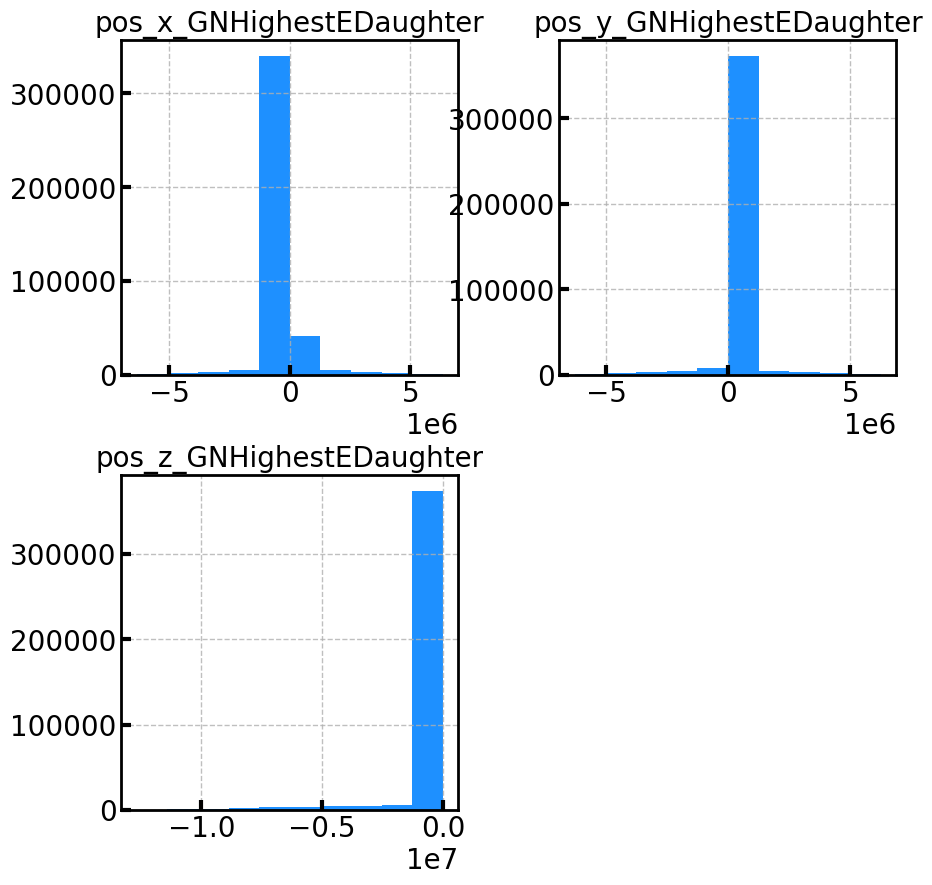

In [231]:
df_TeV_nu_mu_1_truth[['pos_x_GNHighestEDaughter', 'pos_y_GNHighestEDaughter', 'pos_z_GNHighestEDaughter']].hist(bins=10, figsize=(10, 10))

In [232]:
df_TeV_nu_mu_1_truth[['dir_x_GNHighestEInIceParticle', 'dir_y_GNHighestEInIceParticle', 'dir_z_GNHighestEInIceParticle']].head()

dir_x_GNHighestEInIceParticle  dir_y_GNHighestEInIceParticle  \
0                       0.347681                       0.814321   
1                      -0.489351                      -0.776384   
2                       0.159292                      -0.131089   
3                      -0.795297                      -0.008760   
4                       0.702390                       0.289844   

   dir_z_GNHighestEInIceParticle  
0                      -0.464758  
1                      -0.397194  
2                       0.978489  
3                      -0.606157  
4                      -0.650106

In [233]:
df_TeV_nu_mu_1_truth[['dir_x_GNHighestEInIceParticle', 'dir_y_GNHighestEInIceParticle', 'dir_z_GNHighestEInIceParticle']].describe()

dir_x_GNHighestEInIceParticle  dir_y_GNHighestEInIceParticle  \
count                  400561.000000                  400561.000000   
mean                        0.000835                      -0.000235   
std                         0.576779                       0.579123   
min                        -0.999985                      -0.999987   
25%                        -0.497352                      -0.501769   
50%                         0.000828                       0.000383   
75%                         0.498004                       0.500738   
max                         0.999996                       0.999994   

       dir_z_GNHighestEInIceParticle  
count                  400561.000000  
mean                       -0.170352  
std                         0.550386  
min                        -0.999992  
25%                        -0.608786  
50%                        -0.272234  
75%                         0.235693  
max                         0.999995

array([[<Axes: title={'center': 'dir_x_GNHighestEInIceParticle'}>,
        <Axes: title={'center': 'dir_y_GNHighestEInIceParticle'}>],
       [<Axes: title={'center': 'dir_z_GNHighestEInIceParticle'}>,
        <Axes: >]], dtype=object)

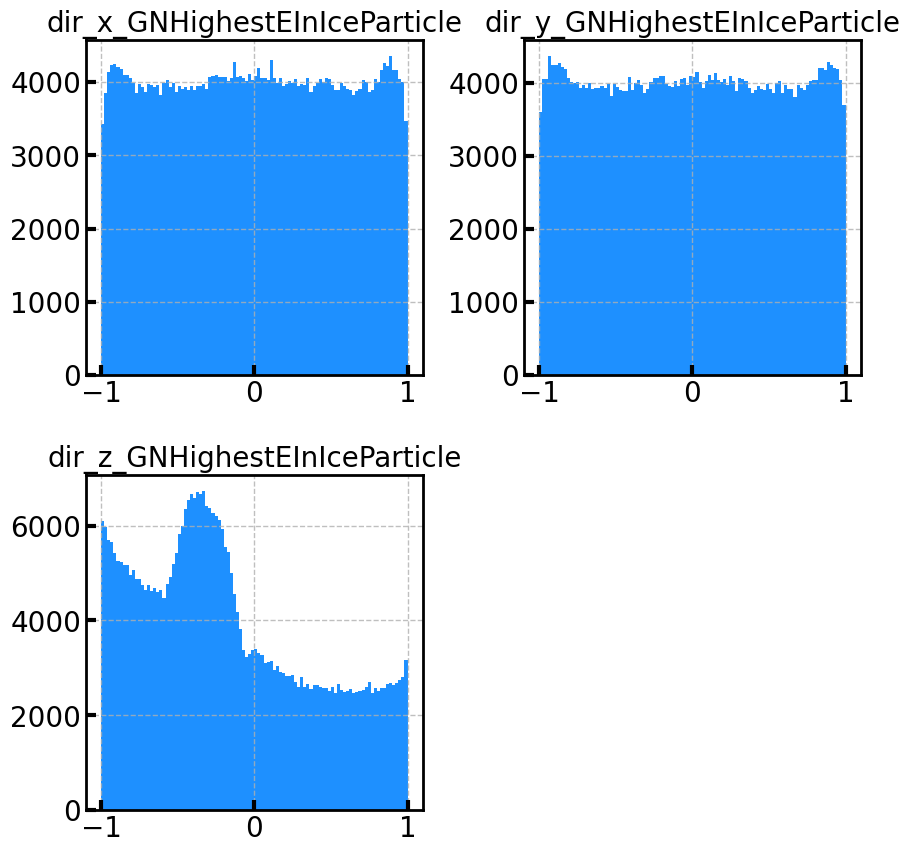

In [234]:
df_TeV_nu_mu_1_truth[['dir_x_GNHighestEInIceParticle', 'dir_y_GNHighestEInIceParticle', 'dir_z_GNHighestEInIceParticle']].hist(bins=100, figsize=(10, 10))

In [235]:
df_TeV_nu_mu_1_truth[['dir_x_GNHighestEDaughter', 'dir_y_GNHighestEDaughter', 'dir_z_GNHighestEDaughter']].head()

dir_x_GNHighestEDaughter  dir_y_GNHighestEDaughter  \
0                  0.347681                  0.814321   
1                 -0.826932                  0.558154   
2                  0.156758                 -0.130822   
3                 -0.795297                 -0.008760   
4                  0.702985                  0.296422   

   dir_z_GNHighestEDaughter  
0                 -0.464758  
1                 -0.068179  
2                  0.978934  
3                 -0.606157  
4                 -0.646487

In [236]:
df_TeV_nu_mu_1_truth[['dir_x_GNHighestEDaughter', 'dir_y_GNHighestEDaughter', 'dir_z_GNHighestEDaughter']].describe()

dir_x_GNHighestEDaughter  dir_y_GNHighestEDaughter  \
count             400561.000000             400561.000000   
mean                   0.000812                 -0.000547   
std                    0.580651                  0.583161   
min                   -0.999985                 -0.999987   
25%                   -0.503925                 -0.508627   
50%                    0.001126                 -0.000419   
75%                    0.504442                  0.507427   
max                    0.999996                  0.999994   

       dir_z_GNHighestEDaughter  
count             400561.000000  
mean                  -0.134468  
std                    0.551985  
min                   -0.999992  
25%                   -0.570369  
50%                   -0.231710  
75%                    0.290924  
max                    0.999997

array([[<Axes: title={'center': 'dir_x_GNHighestEDaughter'}>,
        <Axes: title={'center': 'dir_y_GNHighestEDaughter'}>],
       [<Axes: title={'center': 'dir_z_GNHighestEDaughter'}>, <Axes: >]],
      dtype=object)

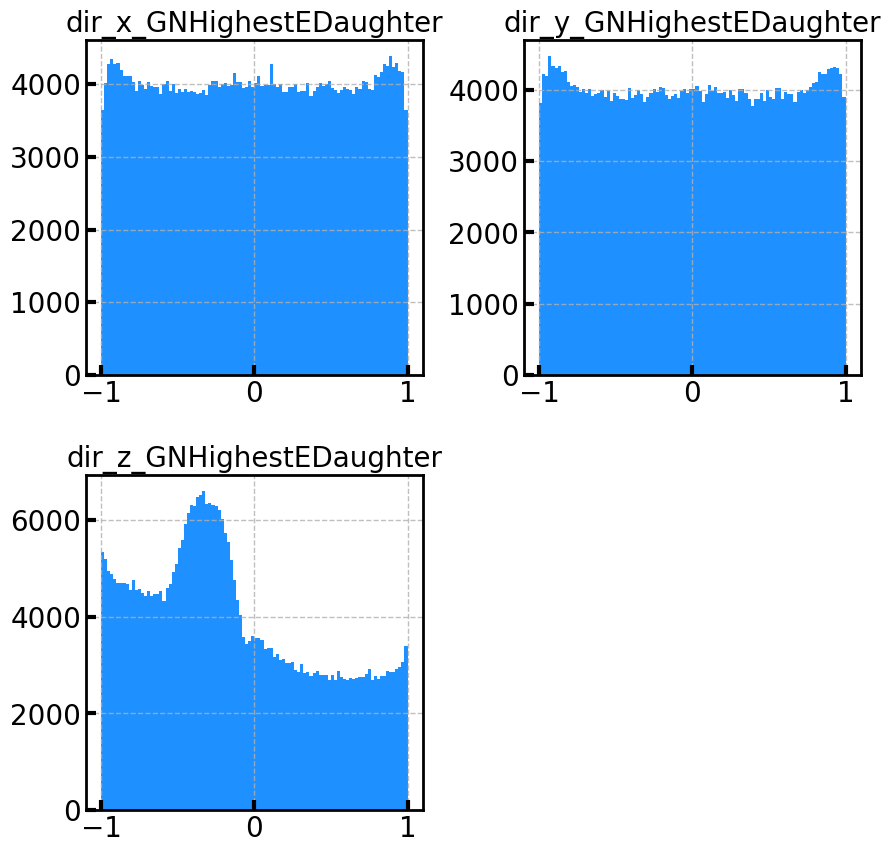

In [237]:
df_TeV_nu_mu_1_truth[['dir_x_GNHighestEDaughter', 'dir_y_GNHighestEDaughter', 'dir_z_GNHighestEDaughter']].hist(bins=100, figsize=(10, 10))

/groups/icecube/cyan/.local/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


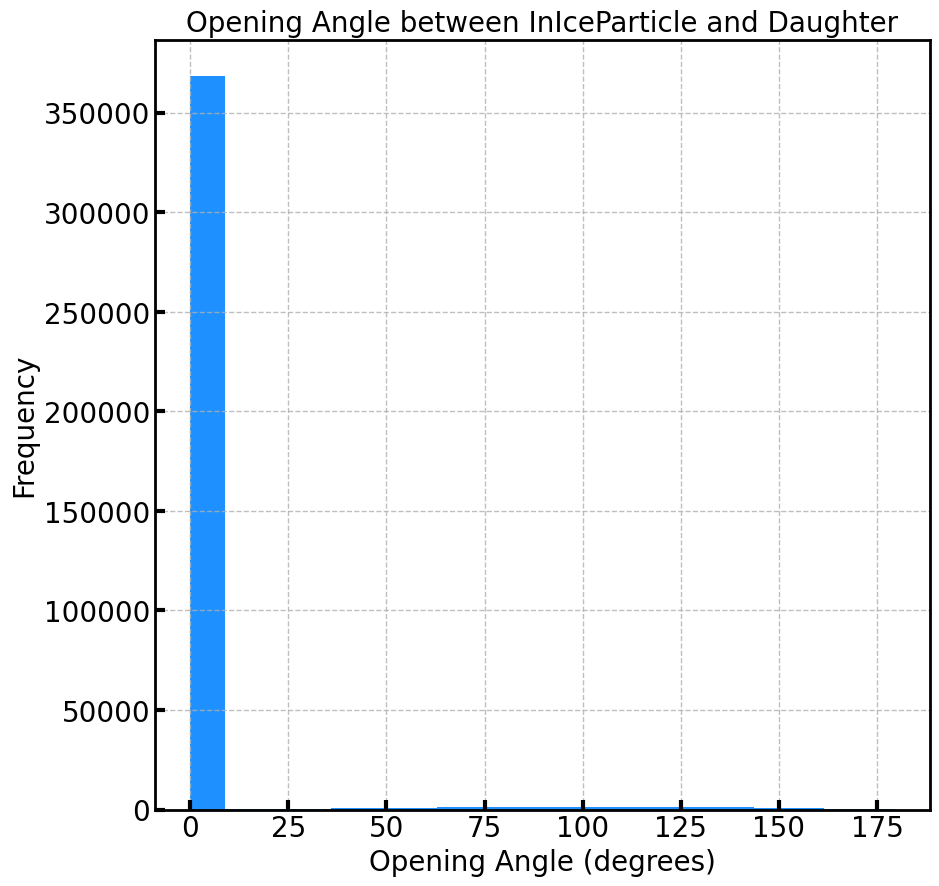

In [238]:
def see_opening_angle(whole_df):
    df = whole_df[:]
    x = df['dir_x_GNHighestEInIceParticle'] * df['dir_x_GNHighestEDaughter']
    y = df['dir_y_GNHighestEInIceParticle'] * df['dir_y_GNHighestEDaughter']
    z = df['dir_z_GNHighestEInIceParticle'] * df['dir_z_GNHighestEDaughter']
    cos_theta = x + y + z
    theta = np.arccos(cos_theta)
    theta = np.degrees(theta)
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.hist(theta, bins=20)
    ax.set_xlabel("Opening Angle (degrees)")
    ax.set_ylabel("Frequency")
    ax.set_title("Opening Angle between InIceParticle and Daughter")
see_opening_angle(df_TeV_nu_mu_1_truth)


In [239]:
df_TeV_nu_mu_1_truth['isWithinIceCube']

0         0
1         0
2         0
3         1
4         0
         ..
400556    0
400557    1
400558    0
400559    0
400560    1
Name: isWithinIceCube, Length: 400561, dtype: int32

### suddenly it's clear

In [240]:
def is_point_on_plane(point: np.ndarray, plane_func, tol=1e-6):
    return abs(plane_func(point)) < tol


In [ ]:
def build_8_plane_equations():
    ICECUBE_VERTEX = {
        0: np.array([(269.70961549, 548.30058428, 524.56), (269.70961549, 548.30058428, -512.82)]),
        1: np.array([(576.36999512, 170.91999817, 524.56), (576.36999512, 170.91999817, -512.82)]),
        2: np.array([(361.0, -422.82998657, 524.56), (361.0, -422.82998657, -512.82)]),
        3: np.array([(-256.14001465, -521.08001709, 524.56), (-256.14001465, -521.08001709, -512.82)]),
        4: np.array([(-570.90002441, -125.13999939, 524.56), (-570.90002441, -125.13999939, -512.82)]),
        5: np.array([(-347.88000488, 451.51998901, 524.56), (-347.88000488, 451.51998901, -512.82)]),
    }

    planes = []

    # Create rectangular face planes
    n_faces = len(ICECUBE_VERTEX)
    for i in range(n_faces):
        point1, point2 = ICECUBE_VERTEX[i]
        point3 = ICECUBE_VERTEX[(i + 1) % n_faces][0]  # Next face's first point
        plane_func, bounds_check = define_plane(point1, point2, point3)
        planes.append((plane_func, bounds_check))

    # Extract hexagon vertices for bases
    hexagon_vertices = [(ICECUBE_VERTEX[i][0][0], ICECUBE_VERTEX[i][0][1]) for i in range(n_faces)]

    # Create hexagonal base planes
    for z_value in [524.56, -512.82]:  # Lid and Floor
        plane_func, _ = define_plane(
            np.array([hexagon_vertices[0][0], hexagon_vertices[0][1], z_value]),
            np.array([hexagon_vertices[1][0], hexagon_vertices[1][1], z_value]),
            np.array([hexagon_vertices[2][0], hexagon_vertices[2][1], z_value])
        )
        bounds_check = lambda p: is_inside_hexagon(p, hexagon_vertices)
        planes.append((plane_func, bounds_check))

    return planes
build_8_plane_equations()

[(<function __main__.define_plane.<locals>.<lambda>(r)>,
  <function __main__.define_plane.<locals>.is_inside_bounds(point)>),
 (<function __main__.define_plane.<locals>.<lambda>(r)>,
  <function __main__.define_plane.<locals>.is_inside_bounds(point)>),
 (<function __main__.define_plane.<locals>.<lambda>(r)>,
  <function __main__.define_plane.<locals>.is_inside_bounds(point)>),
 (<function __main__.define_plane.<locals>.<lambda>(r)>,
  <function __main__.define_plane.<locals>.is_inside_bounds(point)>),
 (<function __main__.define_plane.<locals>.<lambda>(r)>,
  <function __main__.define_plane.<locals>.is_inside_bounds(point)>),
 (<function __main__.define_plane.<locals>.<lambda>(r)>,
  <function __main__.define_plane.<locals>.is_inside_bounds(point)>),
 (<function __main__.define_plane.<locals>.<lambda>(r)>,
  <function __main__.build_8_plane_equations.<locals>.<lambda>(p)>),
 (<function __main__.define_plane.<locals>.<lambda>(r)>,
  <function __main__.build_8_plane_equations.<locals>.<

In [242]:
def get_lines(df_truth):
    point_x = df_truth['pos_x_GNHighestEDaughter']
    point_y = df_truth['pos_y_GNHighestEDaughter']
    point_z = df_truth['pos_z_GNHighestEDaughter']
    point = np.array([point_x, point_y, point_z])
    
    direction_x = df_truth['dir_x_GNHighestEDaughter']
    direction_y = df_truth['dir_y_GNHighestEDaughter']
    direction_z = df_truth['dir_z_GNHighestEDaughter']
    direction = np.array([direction_x, direction_y, direction_z])
    
    lines = []
    for i, p, d in zip(df_truth.index, point.T, direction.T):
        if np.linalg.norm(d) < 1e-8:
            print(f"[Warning] Direction vector is nearly zero at index {i}, skipping.")
            lines.append(None)  # Placeholder to keep alignment
            continue
        lines.append(define_line(p, d))
    return lines

In [258]:
def intersect_line_with_plane(line_func, plane_func, bounds_check, t_range=(-1e3, 1e3), num=10_000):
    """
    Intersect a parametric line function with a plane function and check if the intersection
    is within the valid region of the plane.

    Handles edge cases where the line lies on the plane (coplanar).
    """
    ts = np.linspace(*t_range, num)
    values = np.array([plane_func(line_func(t)) for t in ts])

    # --- Case: line is coplanar with plane ---
    if np.allclose(values, 0, atol=1e-6):
        print("[Info] Line is coplanar with plane.")
        # Use start/end as potential intersections if inside bounds
        start_point = line_func(ts[0])
        end_point = line_func(ts[-1])
        points = []

        if bounds_check(start_point):
            points.append(start_point)
        if bounds_check(end_point):
            points.append(end_point)

        return points

    # --- Normal case: sign change logic ---
    sign_changes = np.where(np.diff(np.sign(values)) != 0)[0]

    raw_points = []
    for idx in sign_changes:
        t1, t2 = ts[idx], ts[idx + 1]
        v1, v2 = values[idx], values[idx + 1]

        if np.isclose(v1, 0):
            t_star = t1
        elif np.isclose(v2, 0):
            t_star = t2
        else:
            t_star = t1 - v1 * (t2 - t1) / (v2 - v1)  # Linear interpolation

        point = line_func(t_star)

        if bounds_check(point):
            raw_points.append(point)

    # --- Remove near-duplicates ---
    distinct_points = []
    tol = 1e-4
    for pt in raw_points:
        if all(np.linalg.norm(pt - other) > tol for other in distinct_points):
            distinct_points.append(pt)
        else:
            print("[Info] Skipping near-duplicate intersection point")

    return distinct_points


In [259]:
def find_line_plane_intersections(lines, planes):
    """
    Finds intersection points for each line with all given planes.

    Args:
        lines: List of line functions.
        planes: List of (plane_func, bounds_check) tuples.

    Returns:
        List of intersection points for each line (0, 1, or 2 per line).
    """
    all_intersections = []
    for line in tqdm(lines, desc="Processing Lines"):
        intersections = []
        if line is None:
            all_intersections.append([])  # No intersections
            continue
        for plane_func, bounds_check in planes:
            pts = intersect_line_with_plane(line, plane_func, bounds_check)
            intersections.extend(pts)
        all_intersections.append(intersections)
    return all_intersections


In [260]:
reduced_df = df_TeV_nu_mu_1_truth[:100]
rediced_lines = get_lines(reduced_df)
all_intersections = find_line_plane_intersections(rediced_lines, build_8_plane_equations())

Processing Lines:   0%|          | 0/100 [00:00<?, ?it/s]

Processing Lines: 100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


In [246]:
all_intersections[0]

[array([ 178.79681, -451.83713, -338.27362], dtype=float32),
 array([ 309.37344, -146.0072 , -512.82   ], dtype=float32)]

In [247]:
class IntersectionType(Enum):
    NO_INTERSECTION = (0, 0)
    SINGLE_INTERSECTION = (1, 0)  # almost impossible
    ENTRY_EXIT_VERTEX = (2, 0)    # entry point - exit point - vertex
    ENTRY_VERTEX_EXIT = (2, 1)    # entry point - vertex - exit point 
    VERTEX_ENTRY_EXIT = (2, 2)    # vertex - entry point - exit point
    
    def __init__(self, n_intersections: int, geometric_order: int):
        self._n_intersections = n_intersections
        self._geometric_order = geometric_order

    @staticmethod
    def get_intersection_type(n_intersections: int, geometric_order: int):
        for it in IntersectionType:
            if it.n_intersections == n_intersections and it.geometric_order == geometric_order:
                return it
        return IntersectionType.NO_INTERSECTION

    @property
    def n_intersections(self) -> int:
        return self._n_intersections

    @property
    def geometric_order(self) -> int:
        return self._geometric_order

    @property
    def is_lepton_length_valid(self) -> bool:
        return self.geometric_order != 0


In [248]:
def classify_intersections(vertex: np.ndarray, intersections: list, direction: np.ndarray):
    """
    Classifies the geometric order of vertex, entry, and exit along the line.

    Returns:
        entry: np.ndarray
        exit: np.ndarray
        intersection_type: IntersectionType
    """
    if len(intersections) != 2:
        return None, None, IntersectionType.NO_INTERSECTION

    if np.linalg.norm(direction) < 1e-8:
        return None, None, IntersectionType.NO_INTERSECTION

    # Use unit direction vector
    unit_dir = direction / np.linalg.norm(direction)

    def project(p):
        """Signed scalar projection along direction from vertex."""
        return np.dot(p - vertex, unit_dir)

    # Projections
    t0 = project(intersections[0])
    t1 = project(intersections[1])
    t_vertex = 0.0  # vertex is the origin of projection

    # Sort points by projection value
    if t0 < t1:
        entry, exit = intersections[0], intersections[1]
        ts = [t0, t1, t_vertex]
    else:
        entry, exit = intersections[1], intersections[0]
        ts = [t1, t0, t_vertex]

    # Diagnostic logs
    if np.isclose(t0, t1, atol=1e-6):
        print("[Warning] Entry and exit are extremely close after projection.")
    if t_vertex < min(t0, t1) or t_vertex > max(t0, t1):
        print("[Warning] Vertex lies outside the entry-exit segment.")

    # Determine geometric order
    order = sorted(range(3), key=lambda i: ts[i])  # indices of [entry, exit, vertex]
    geometric_order = order.index(2)  # vertex's position
    intersection_type = IntersectionType.get_intersection_type(2, geometric_order)

    return entry, exit, intersection_type


In [249]:
def add_intersection_info_to_df(df_truth, intersections_per_line):
    pos_x_entry, pos_y_entry, pos_z_entry = [], [], []
    pos_x_exit, pos_y_exit, pos_z_exit = [], [], []
    vertex_orders = []
    n_intersections = []

    for i, intersections in enumerate(intersections_per_line):
        row = df_truth.iloc[i]
        vertex = row[['pos_x_GNHighestEDaughter',
                      'pos_y_GNHighestEDaughter',
                      'pos_z_GNHighestEDaughter']].to_numpy(dtype=float)
        direction = row[['dir_x_GNHighestEDaughter',
                         'dir_y_GNHighestEDaughter',
                         'dir_z_GNHighestEDaughter']].to_numpy(dtype=float)

        n = len(intersections)
        n_intersections.append(n)

        if n == 2:
            entry, exit, intersection_type = classify_intersections(vertex, intersections, direction)

            pos_x_entry.append(entry[0])
            pos_y_entry.append(entry[1])
            pos_z_entry.append(entry[2])

            pos_x_exit.append(exit[0])
            pos_y_exit.append(exit[1])
            pos_z_exit.append(exit[2])

            vertex_orders.append(intersection_type.geometric_order)
        else:
            pos_x_entry.append(None)
            pos_y_entry.append(None)
            pos_z_entry.append(None)

            pos_x_exit.append(None)
            pos_y_exit.append(None)
            pos_z_exit.append(None)

            vertex_orders.append(None)

    df_truth = df_truth.copy()
    df_truth['pos_x_entry'] = pos_x_entry
    df_truth['pos_y_entry'] = pos_y_entry
    df_truth['pos_z_entry'] = pos_z_entry

    df_truth['pos_x_exit'] = pos_x_exit
    df_truth['pos_y_exit'] = pos_y_exit
    df_truth['pos_z_exit'] = pos_z_exit

    df_truth['n_intersections'] = n_intersections
    df_truth['intersection_vertex_order'] = vertex_orders

    return df_truth


In [250]:
df_reduced_added = add_intersection_info_to_df(reduced_df, all_intersections)

[Warning] Vertex lies outside the entry-exit segment.
[Warning] Vertex lies outside the entry-exit segment.
[Warning] Vertex lies outside the entry-exit segment.
[Warning] Vertex lies outside the entry-exit segment.
[Warning] Vertex lies outside the entry-exit segment.
[Warning] Vertex lies outside the entry-exit segment.


In [251]:
df_reduced_added[['pos_x_GNHighestEDaughter', 'pos_y_GNHighestEDaughter', 'pos_z_GNHighestEDaughter', 'pos_x_entry', 'pos_y_entry', 'pos_z_entry', 'pos_x_exit', 'pos_y_exit', 'pos_z_exit', 'n_intersections', 'intersection_vertex_order']].head()

pos_x_GNHighestEDaughter  pos_y_GNHighestEDaughter  \
0              3.651696e+02             -1.532417e+01   
1              1.182098e+04             -8.403150e+03   
2             -1.517584e+06              1.267163e+06   
3             -2.162763e+02              3.313105e+01   
4             -1.305044e+03             -4.387455e+02   

   pos_z_GNHighestEDaughter  pos_x_entry  pos_y_entry  pos_z_entry  \
0             -5.874048e+02   178.796814  -451.837128  -338.273621   
1              1.467889e+03          NaN          NaN          NaN   
2             -9.479107e+06          NaN          NaN          NaN   
3              4.480829e+02  -115.935959    34.236240   524.559998   
4              2.508947e+02          NaN          NaN          NaN   

   pos_x_exit  pos_y_exit  pos_z_exit  n_intersections  \
0  309.373444 -146.007202 -512.820007                2   
1         NaN         NaN         NaN                0   
2         NaN         NaN         NaN                0   
3 -510.944794   29.885468  223.493622                2   
4         NaN         NaN         NaN                0   

   intersection_vertex_order  
0                        2.0  
1                        NaN  
2                        NaN  
3                        1.0  
4                        NaN

In [252]:
df_reduced_added['n_intersections'].value_counts()

n_intersections
0    70
2    16
1    14
Name: count, dtype: int64

In [253]:
df_reduced_added_two_intersections = df_reduced_added[df_reduced_added['n_intersections'] == 2]

In [254]:
df_reduced_added_two_intersections.iloc[0]

event_no                     1.110001e+14
original_event_no            0.000000e+00
subdirectory_no              1.100000e+01
part_no                      1.000000e+00
shard_no                     1.000000e+00
                                 ...     
pos_x_exit                   3.093734e+02
pos_y_exit                  -1.460072e+02
pos_z_exit                  -5.128200e+02
n_intersections              2.000000e+00
intersection_vertex_order    2.000000e+00
Name: 0, Length: 137, dtype: float64

In [255]:
df_reduced_added_two_intersections.iloc[1]

event_no                     1.110001e+14
original_event_no            3.000000e+00
subdirectory_no              1.100000e+01
part_no                      1.000000e+00
shard_no                     1.000000e+00
                                 ...     
pos_x_exit                  -5.109448e+02
pos_y_exit                   2.988547e+01
pos_z_exit                   2.234936e+02
n_intersections              2.000000e+00
intersection_vertex_order    1.000000e+00
Name: 3, Length: 137, dtype: float64

In [ ]:
def plot_intersections_and_vertex(df_event, elev=60, azim=240):
    vertex_x = df_event['pos_x_GNHighestEDaughter']
    vertex_y = df_event['pos_y_GNHighestEDaughter']
    vertex_z = df_event['pos_z_GNHighestEDaughter']
    
    entry_x = df_event['pos_x_entry']
    entry_y = df_event['pos_y_entry']
    entry_z = df_event['pos_z_entry']
    
    exit_x = df_event['pos_x_exit']
    exit_y = df_event['pos_y_exit']
    exit_z = df_event['pos_z_exit']

    # Create 3D plot
    fig, ax = plt.subplots(figsize=(18, 14), subplot_kw={'projection': '3d'})
    ax.scatter(vertex_x, vertex_y, vertex_z, color=getColour(0), marker='x', s=100, label='Vertex')
    ax.text(vertex_x, vertex_y, vertex_z, f"({vertex_x:.2f}, {vertex_y:.2f}, {vertex_z:.2f})", fontsize=10, ha='center', color='black')
    ax.scatter(entry_x, entry_y, entry_z, color=getColour(1), marker='o', s=100, label='Entry')
    ax.text(entry_x, entry_y, entry_z, f"({entry_x:.2f}, {entry_y:.2f}, {entry_z:.2f})", fontsize=10, ha='center', color='black')
    ax.scatter(exit_x, exit_y, exit_z, color=getColour(2), marker='o', s=100, label='Exit')
    ax.text(exit_x, exit_y, exit_z, f"({exit_x:.2f}, {exit_y:.2f}, {exit_z:.2f})", fontsize=10, ha='center', color='black')
    
    # connect 
    intersection_type = IntersectionType.get_intersection_type(df_event['n_intersections'], df_event['intersection_vertex_order'])
    if intersection_type == IntersectionType.ENTRY_VERTEX_EXIT:
        # plot a line connecting vertex to exit
        ax.plot([vertex_x, exit_x], [vertex_y, exit_y], [vertex_z, exit_z], linestyle='--', color = getColour(3), label='Vertex to Exit')
        lepton_travel_distance = np.linalg.norm([vertex_x - exit_x, vertex_y - exit_y, vertex_z - exit_z])
    elif intersection_type == IntersectionType.VERTEX_ENTRY_EXIT:
        # plot a line connecting entry to exit
        ax.plot([entry_x, exit_x], [entry_y, exit_y], [entry_z, exit_z], linestyle='--', color = getColour(4), label='Entry to Exit')
        lepton_travel_distance = np.linalg.norm([entry_x - exit_x, entry_y - exit_y, entry_z - exit_z])
    else:
        lepton_travel_distance = 0
    
    
    # Annotate strings with text
    # position_file = "/groups/icecube/cyan/factory/DOMification/dom_ref_pos/unique_string_dom_completed.csv"
    # position_df = pd.read_csv(position_file)
    # for string in position_df['string'].unique():
    #     string_df = position_df[position_df['string'] == string]
    #     top_dom = string_df.loc[string_df['dom_z'].idxmax()]
    #     ax.text(top_dom['dom_x'], top_dom['dom_y'], top_dom['dom_z'],
    #             f'{int(string)}', fontsize=10, ha='center', color='black')
    
    # Plot vertical lines representing Z boundary at key XY points
    
    for x, y in border_xy:
        ax.plot([x, x], [y, y], border_z, color='cyan', alpha=0.5, linestyle='-')
    
    # Set plot labels and title
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    ax.set_zlabel('Z Position')
    ax.legend()
    ax.view_init(elev=elev, azim=azim)
    ax.set_title(f"intersections: event {df_event['event_no']:.0f}")
    is_vertex_in_IceCube = df_event['isWithinIceCube']
    
    d = {"lepton travel length": f"{lepton_travel_distance:.2f} m",
         "vertex in IceCube": "True" if is_vertex_in_IceCube else "False",}

    fig.text(0.25, 0.75, nice_string_output(d), fontsize=14)
    
    plt.show()


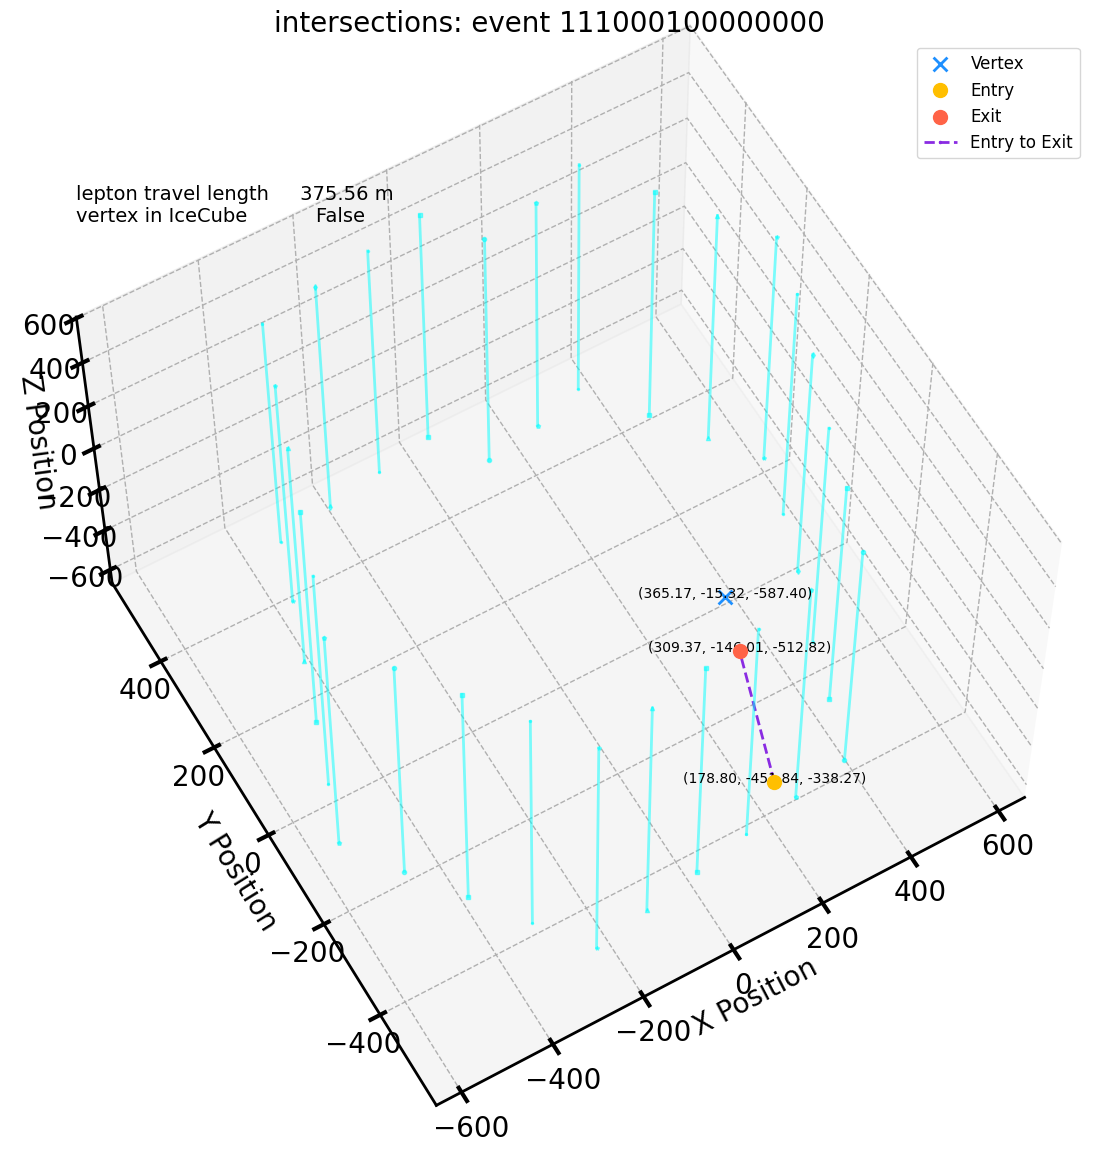

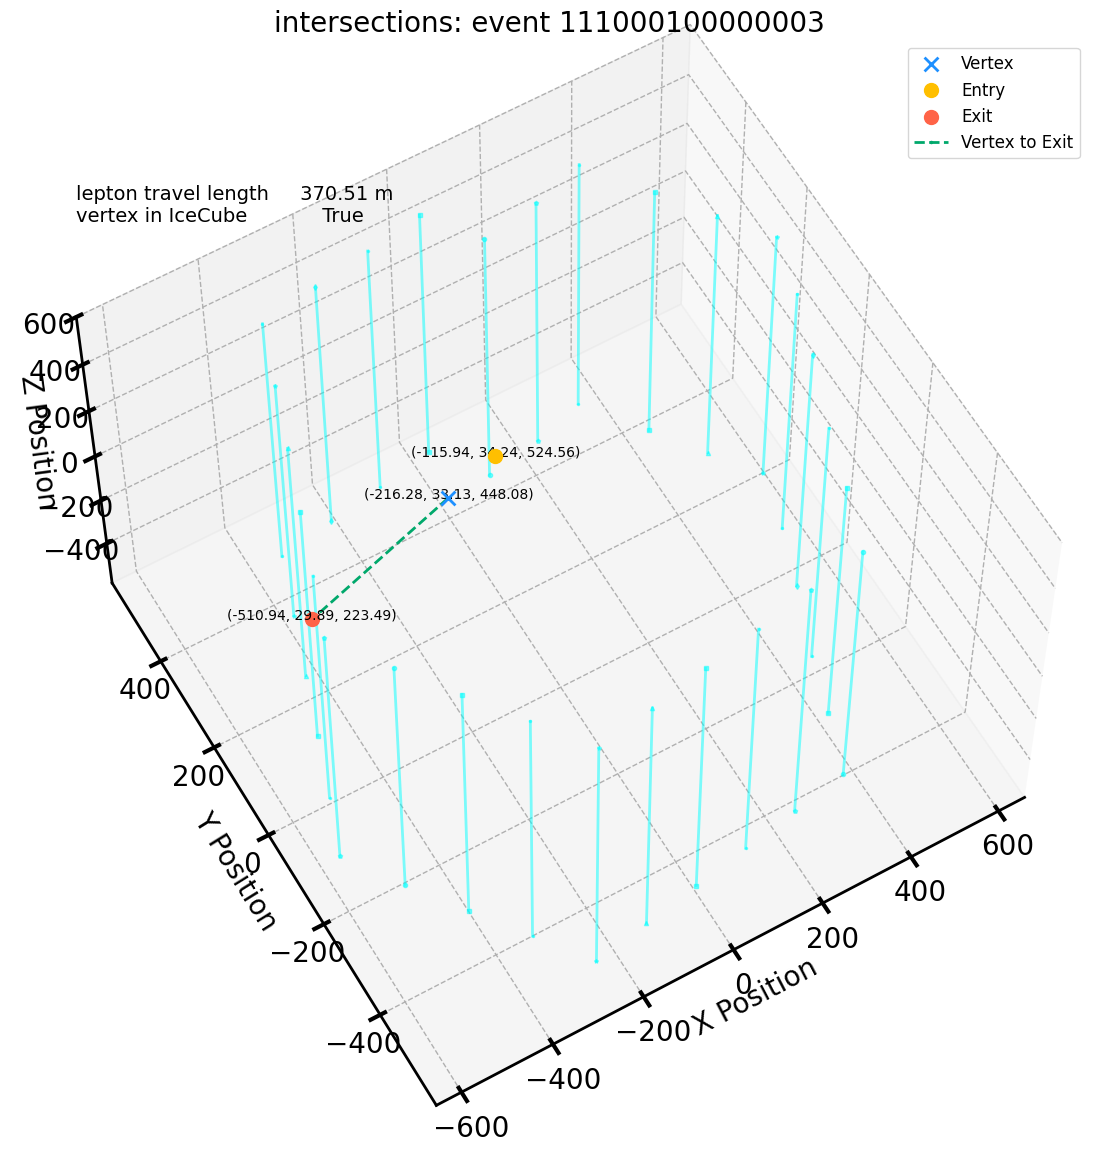

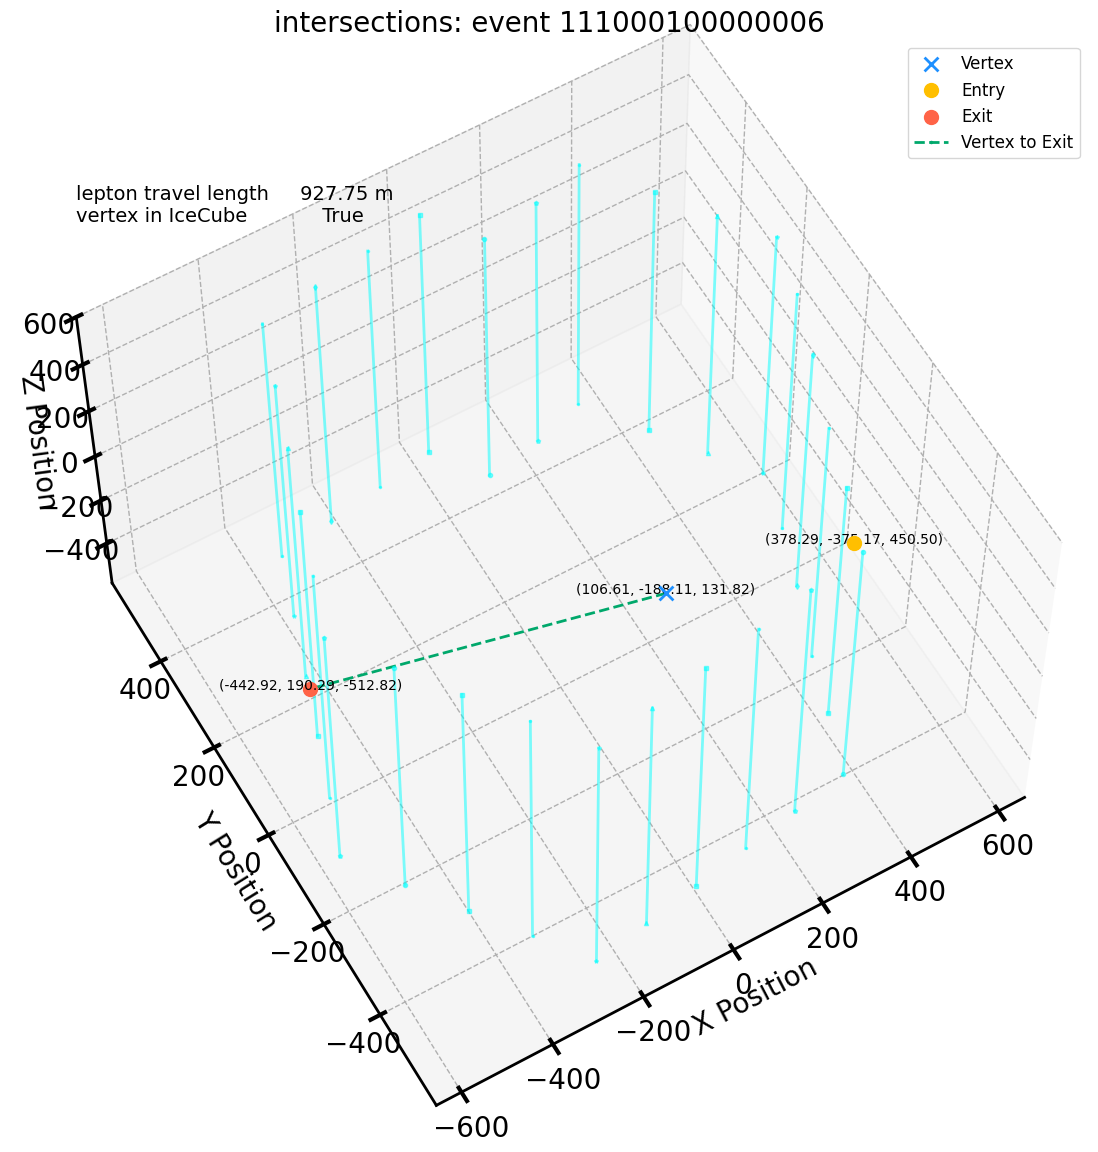

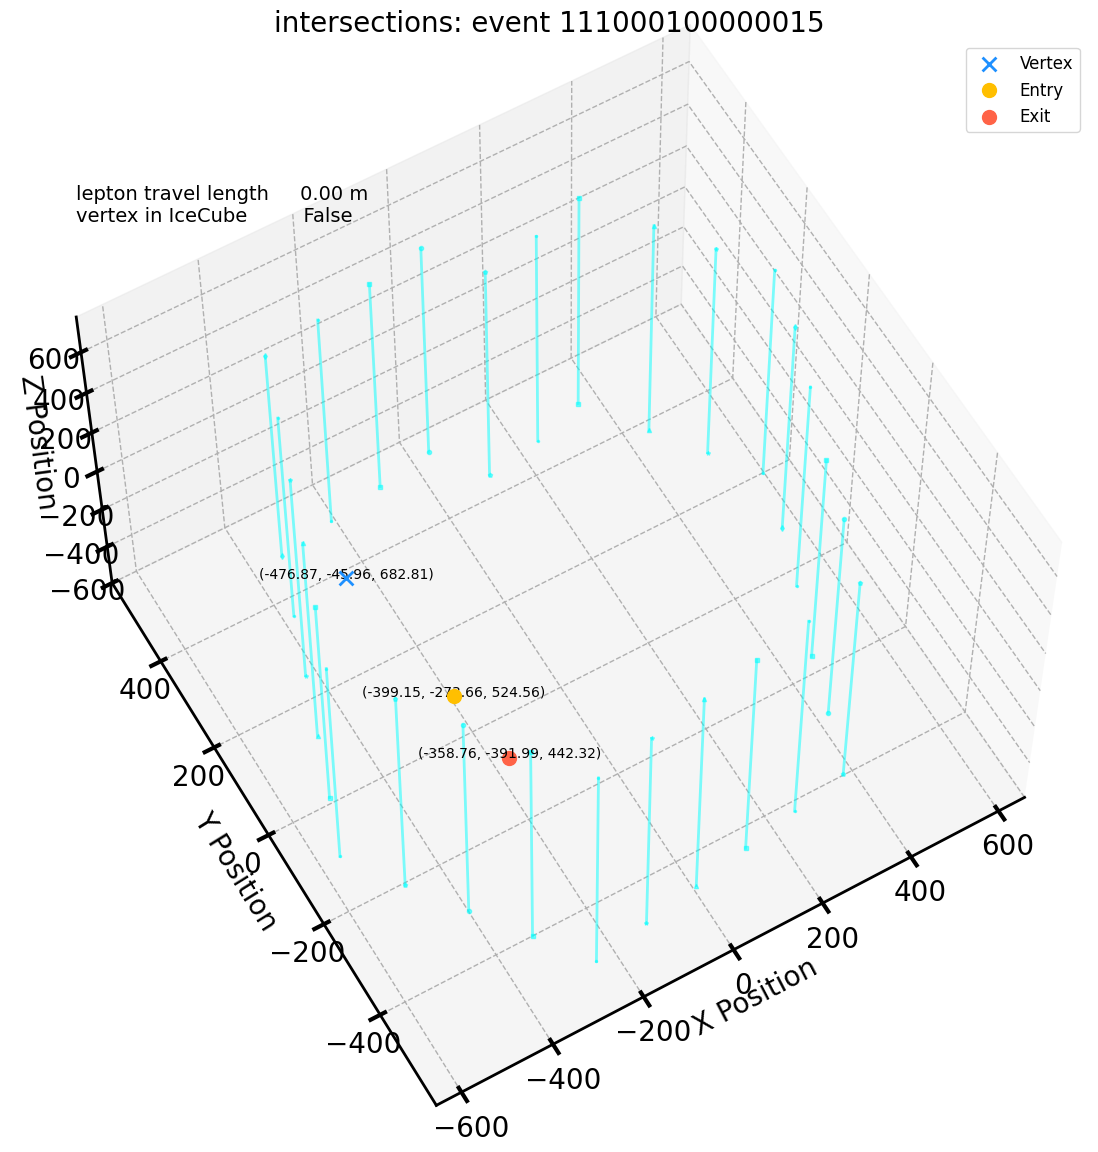

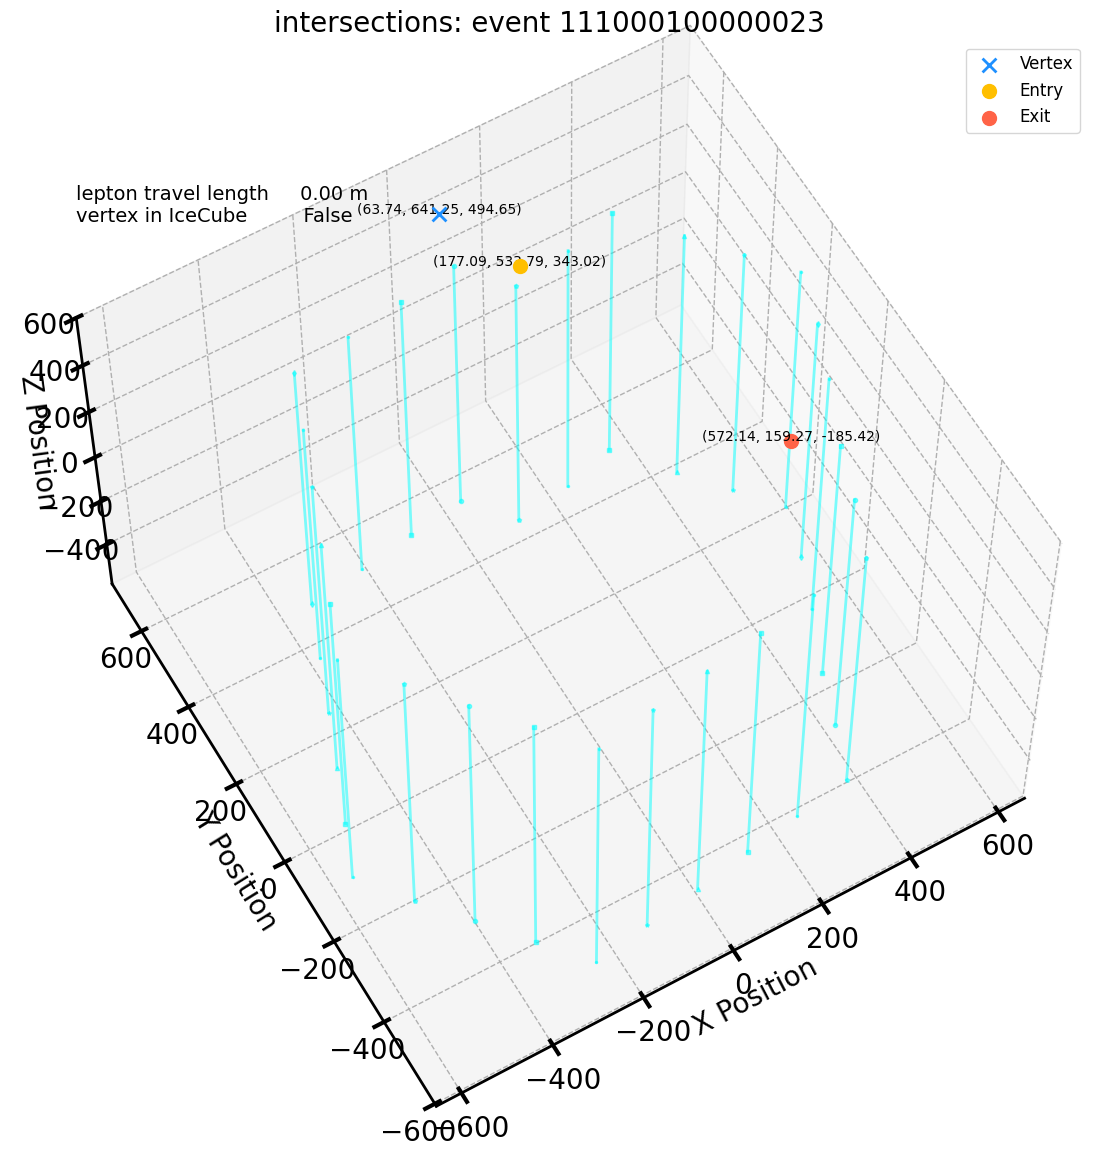

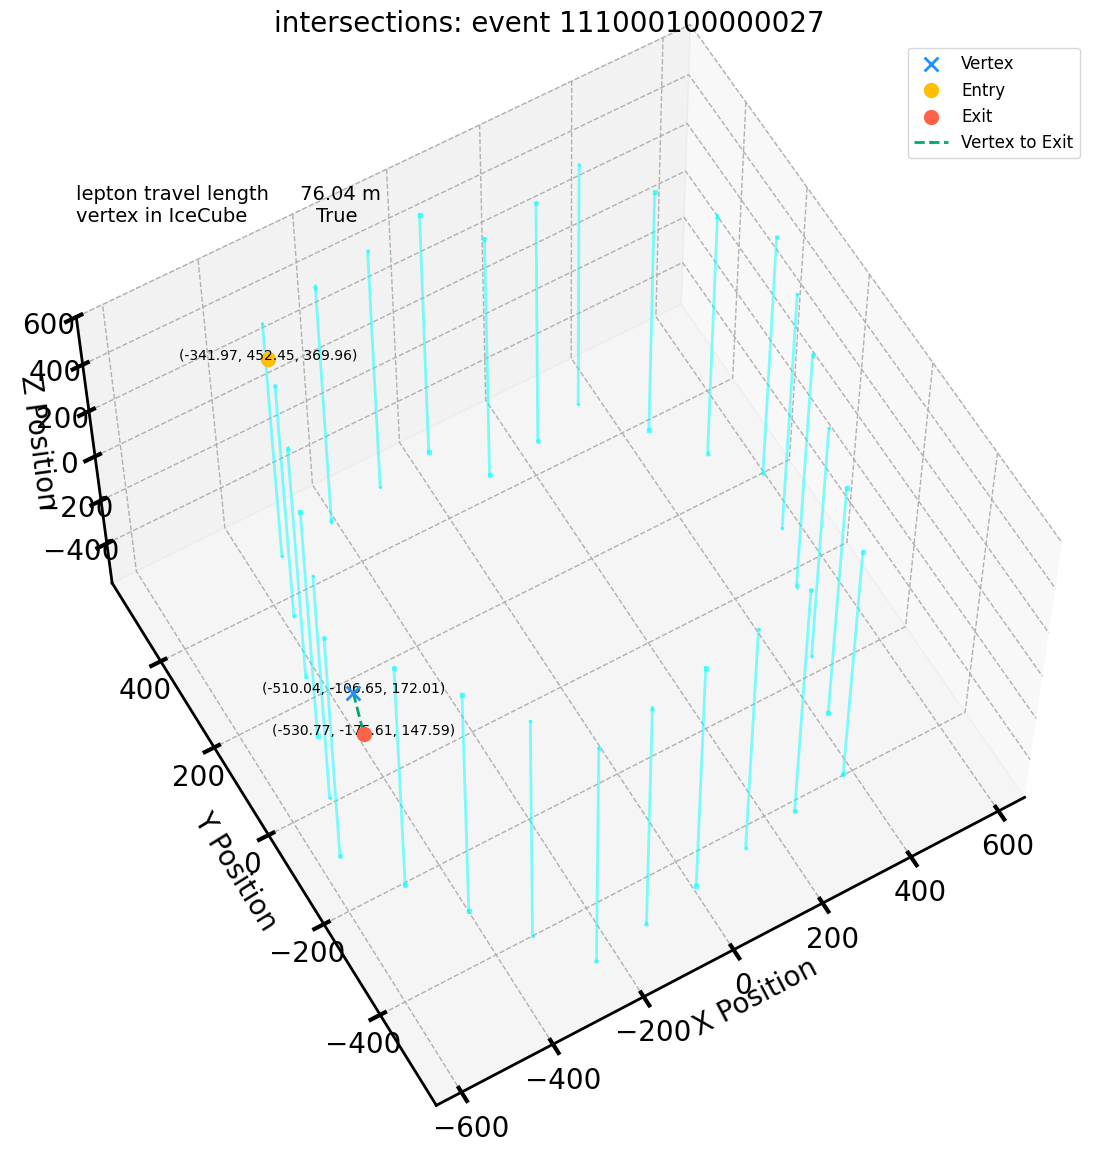

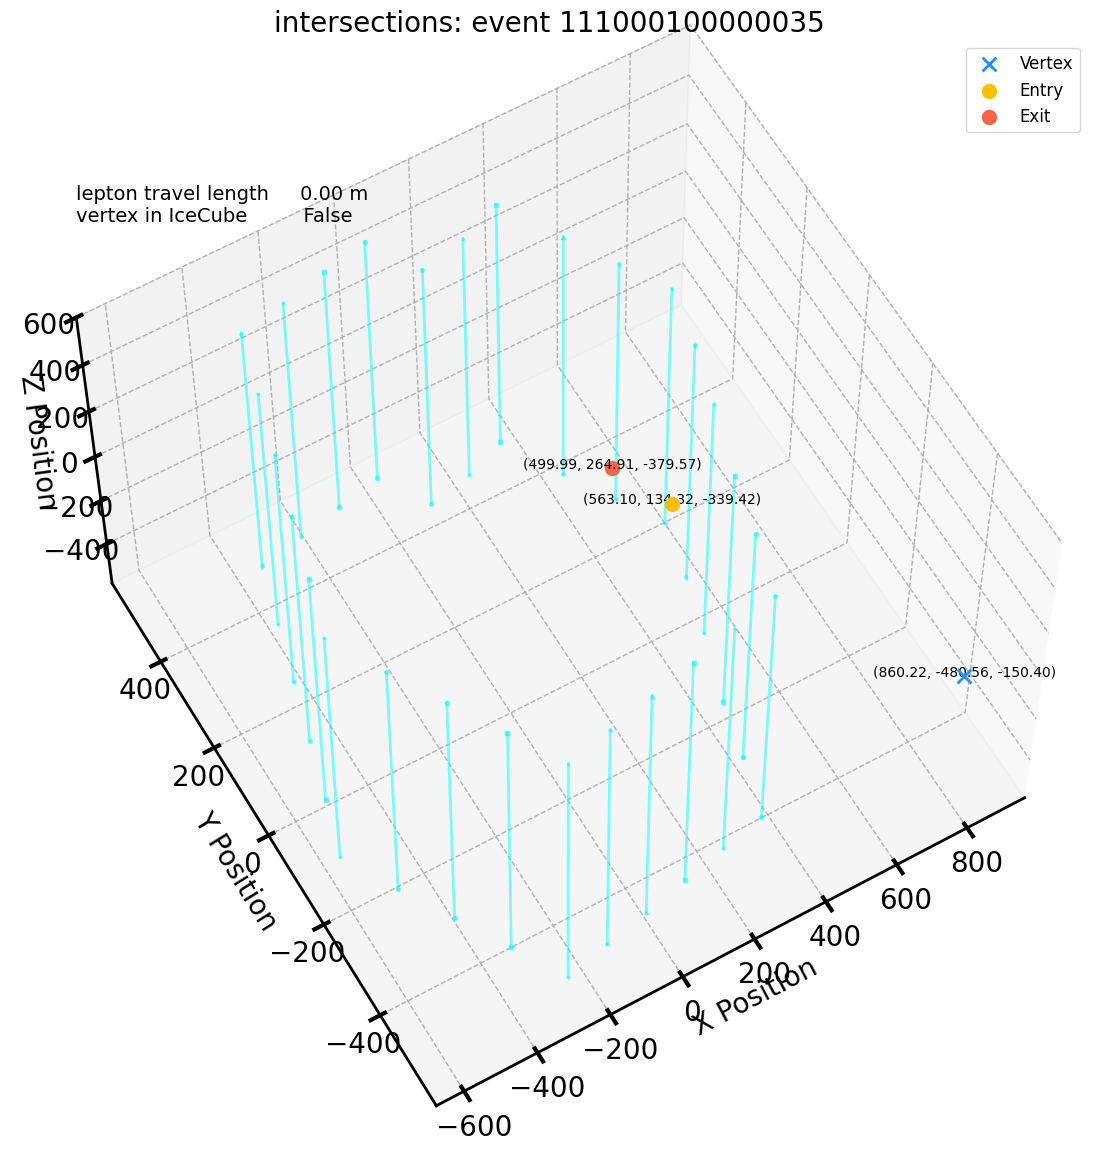

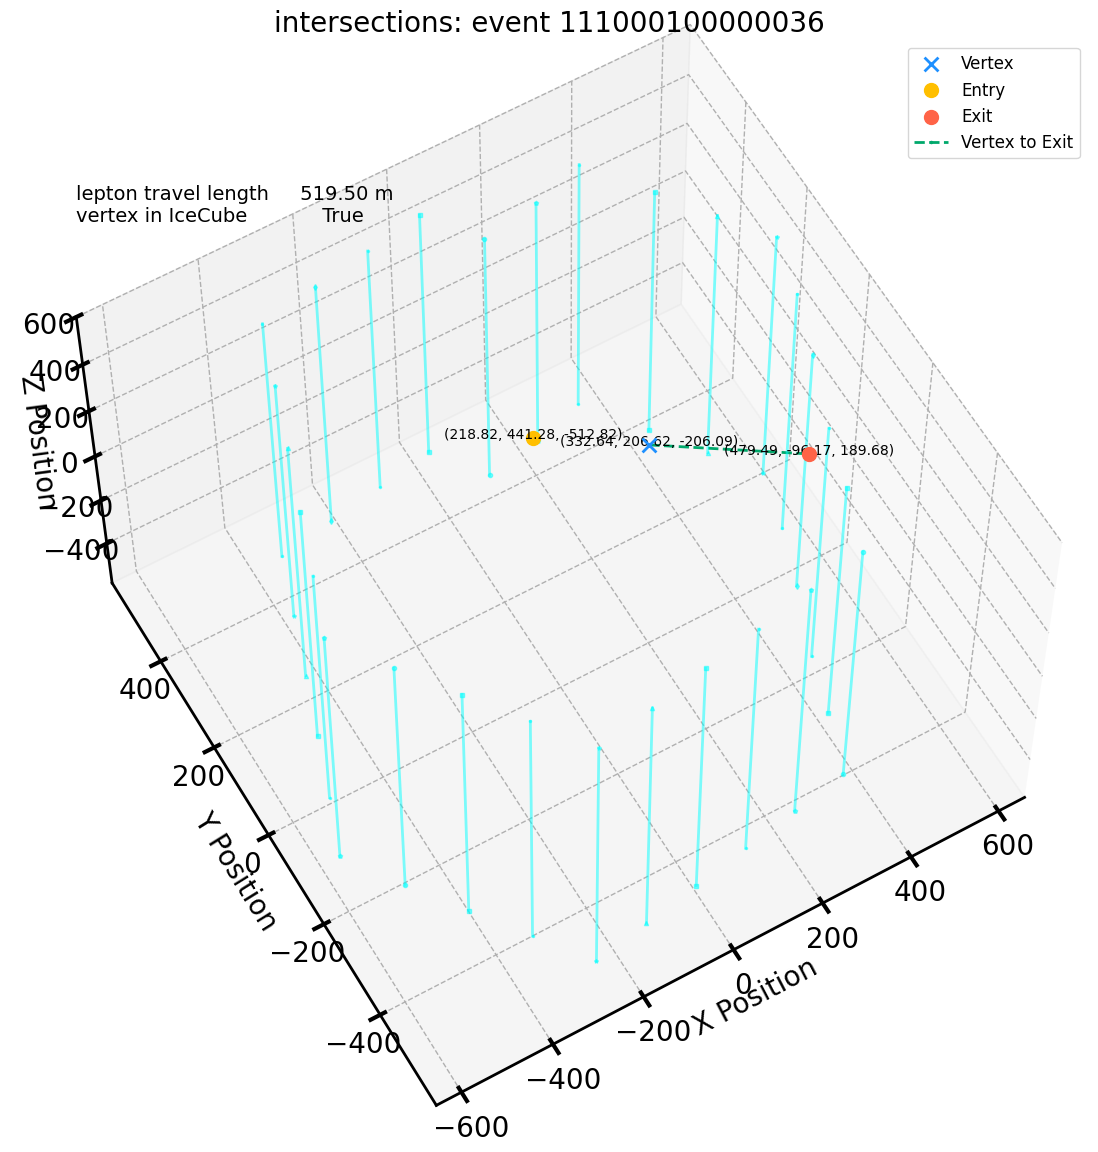

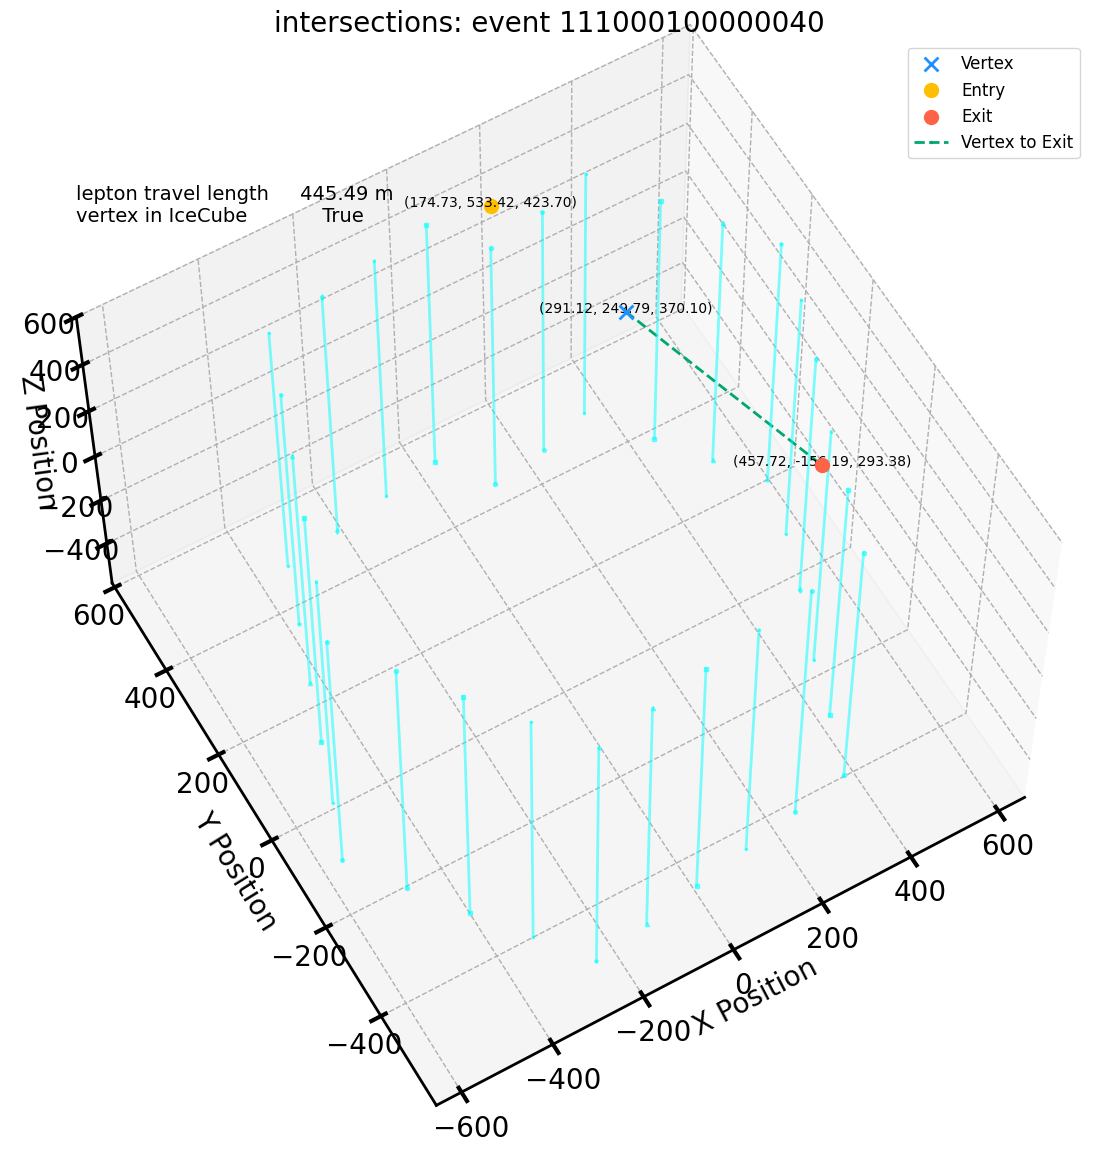

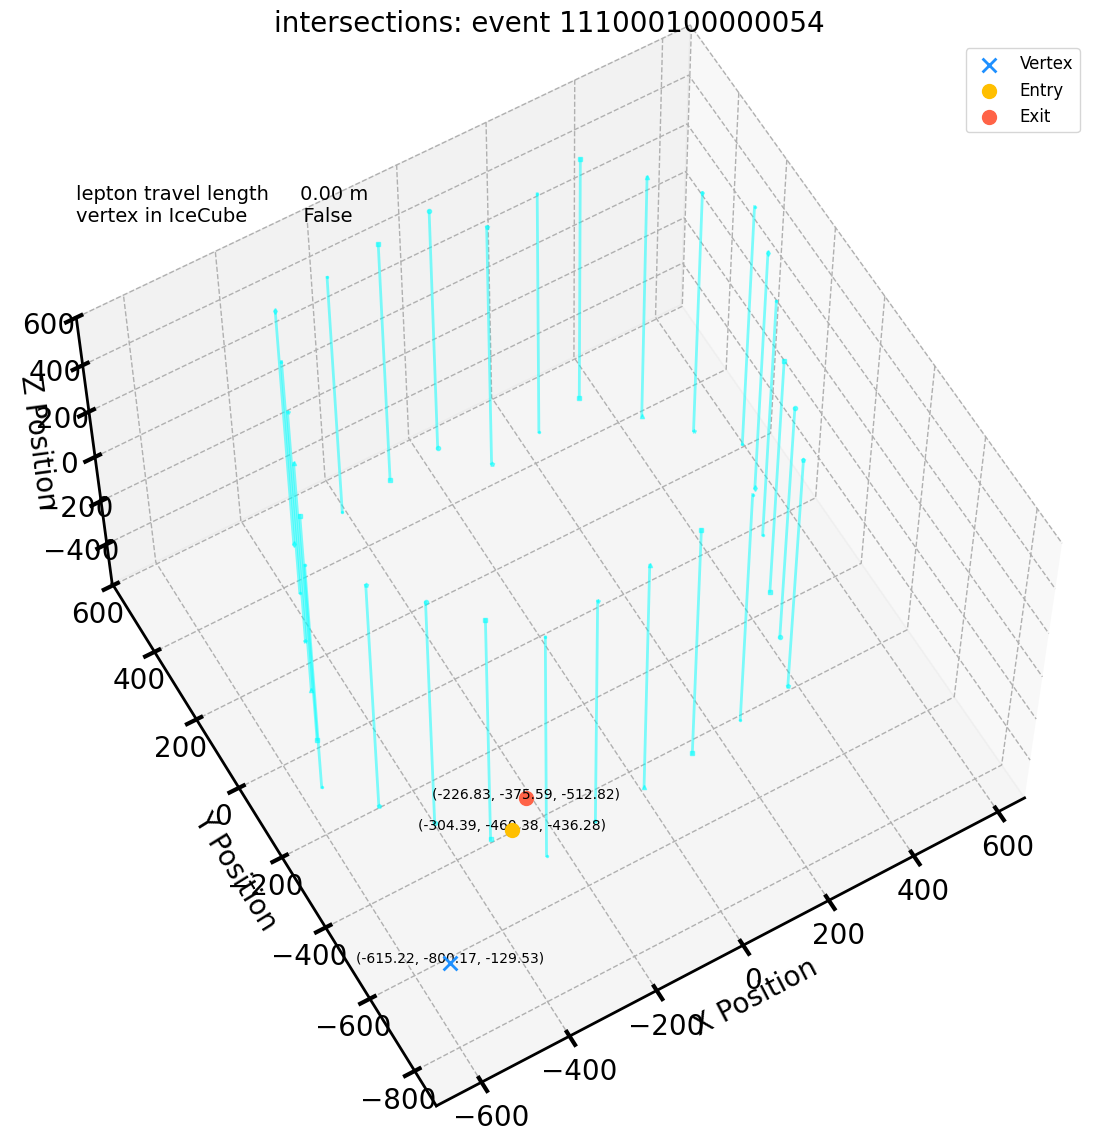

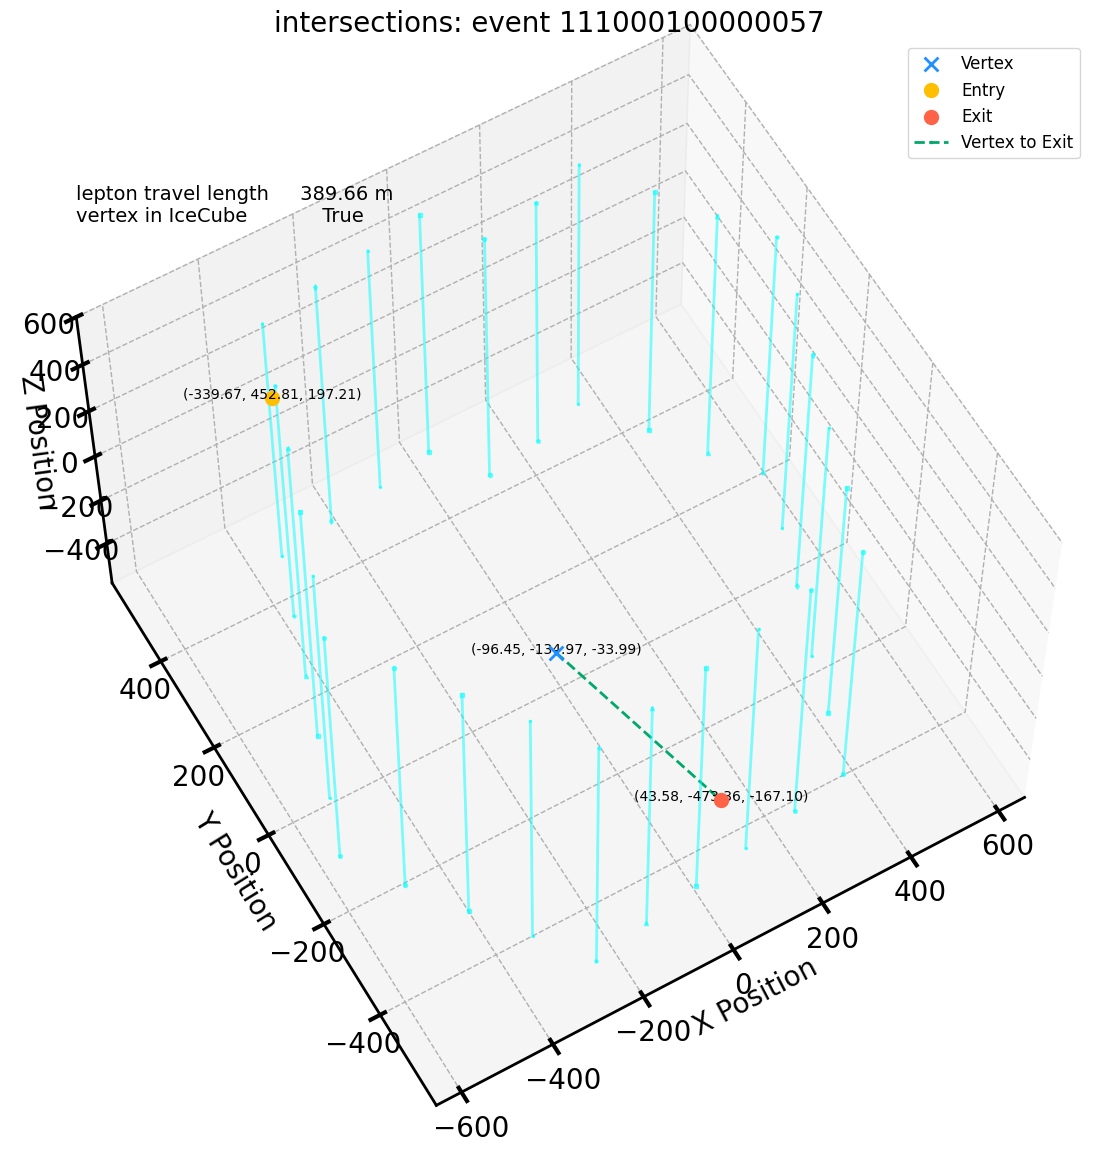

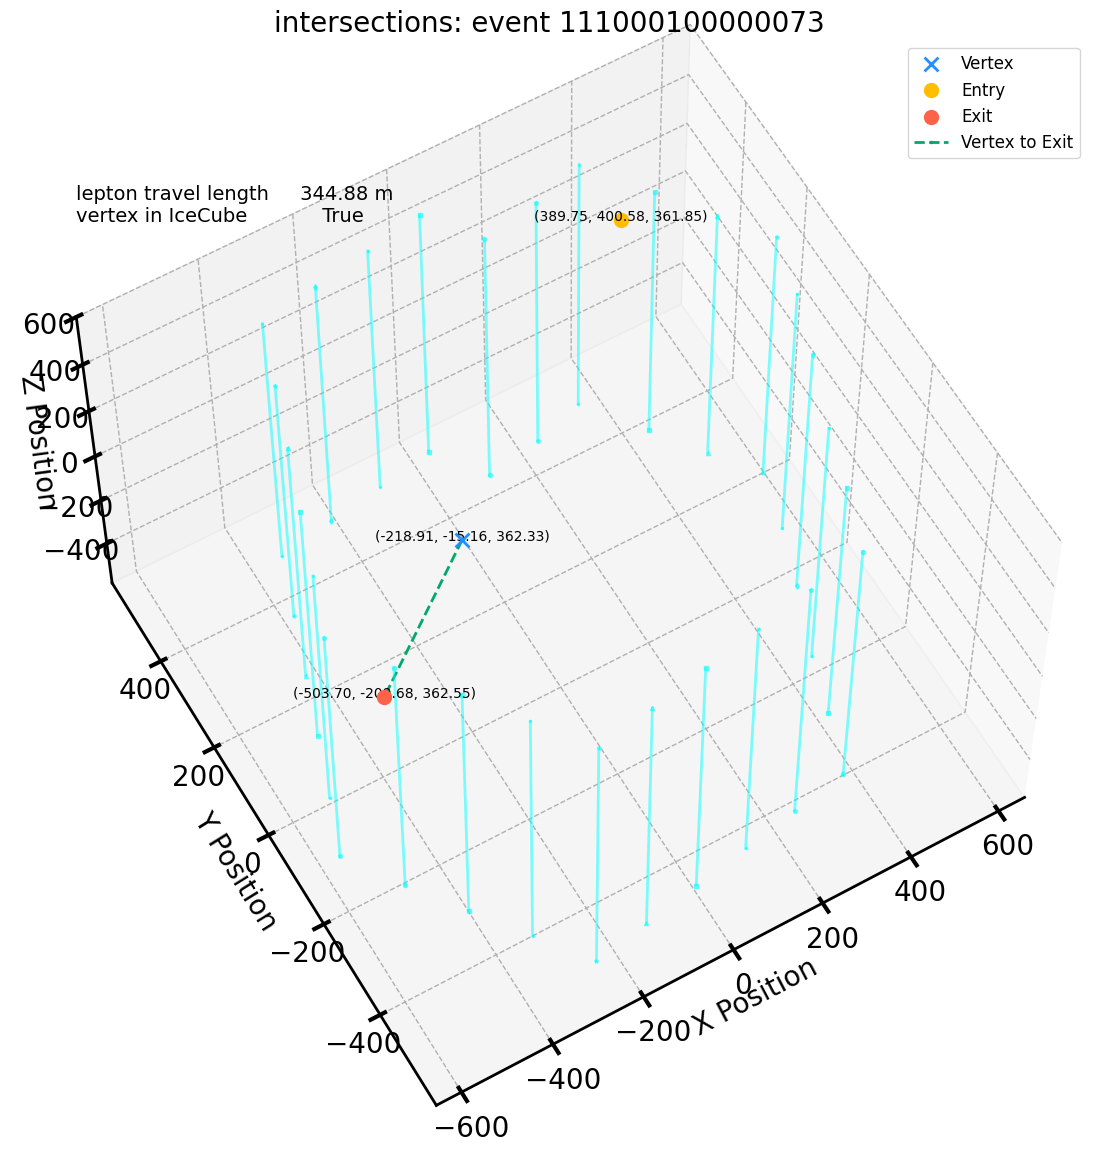

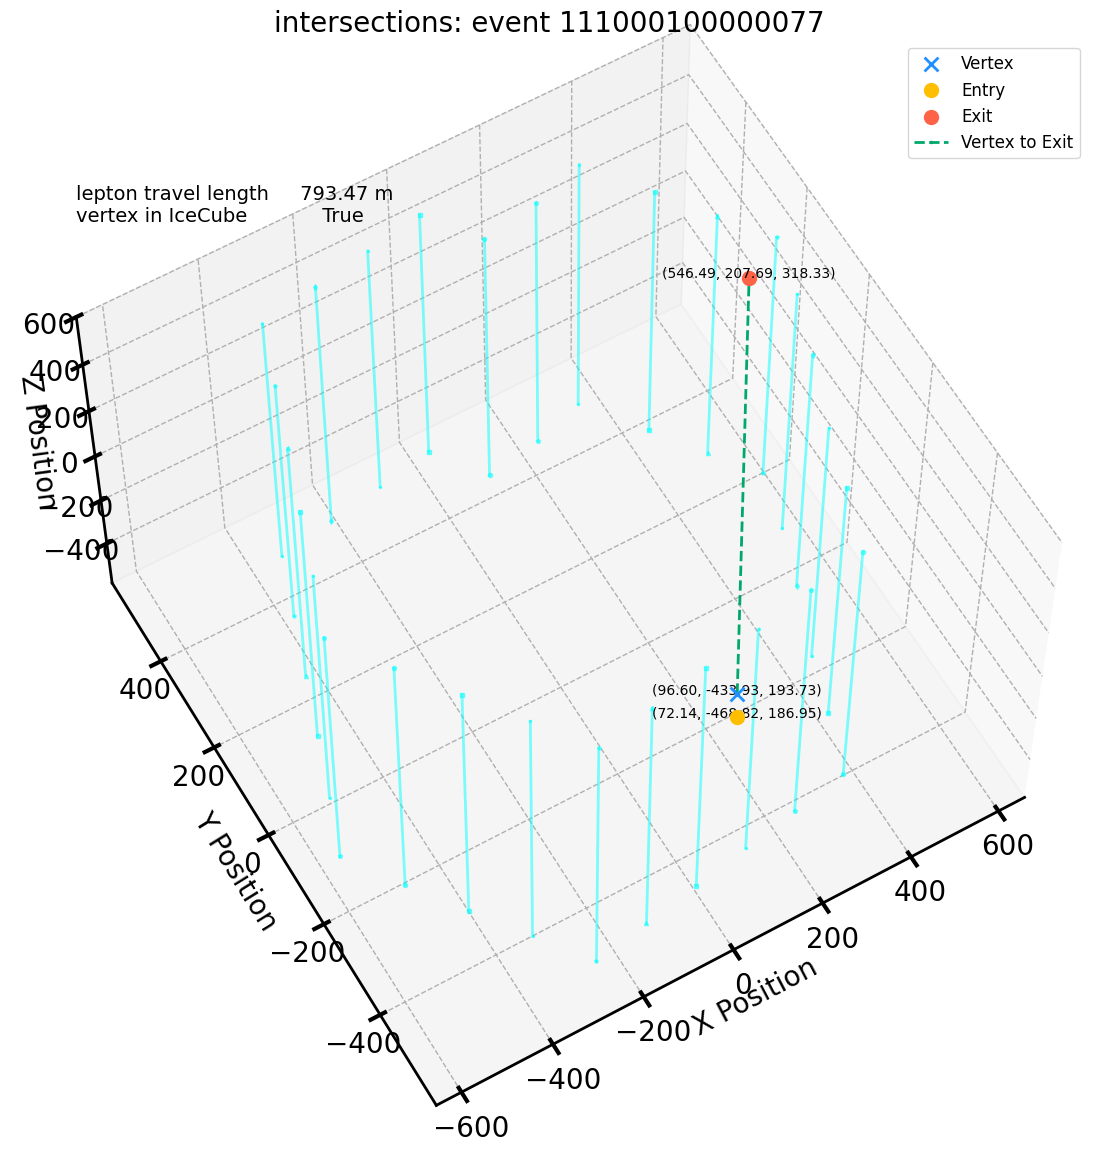

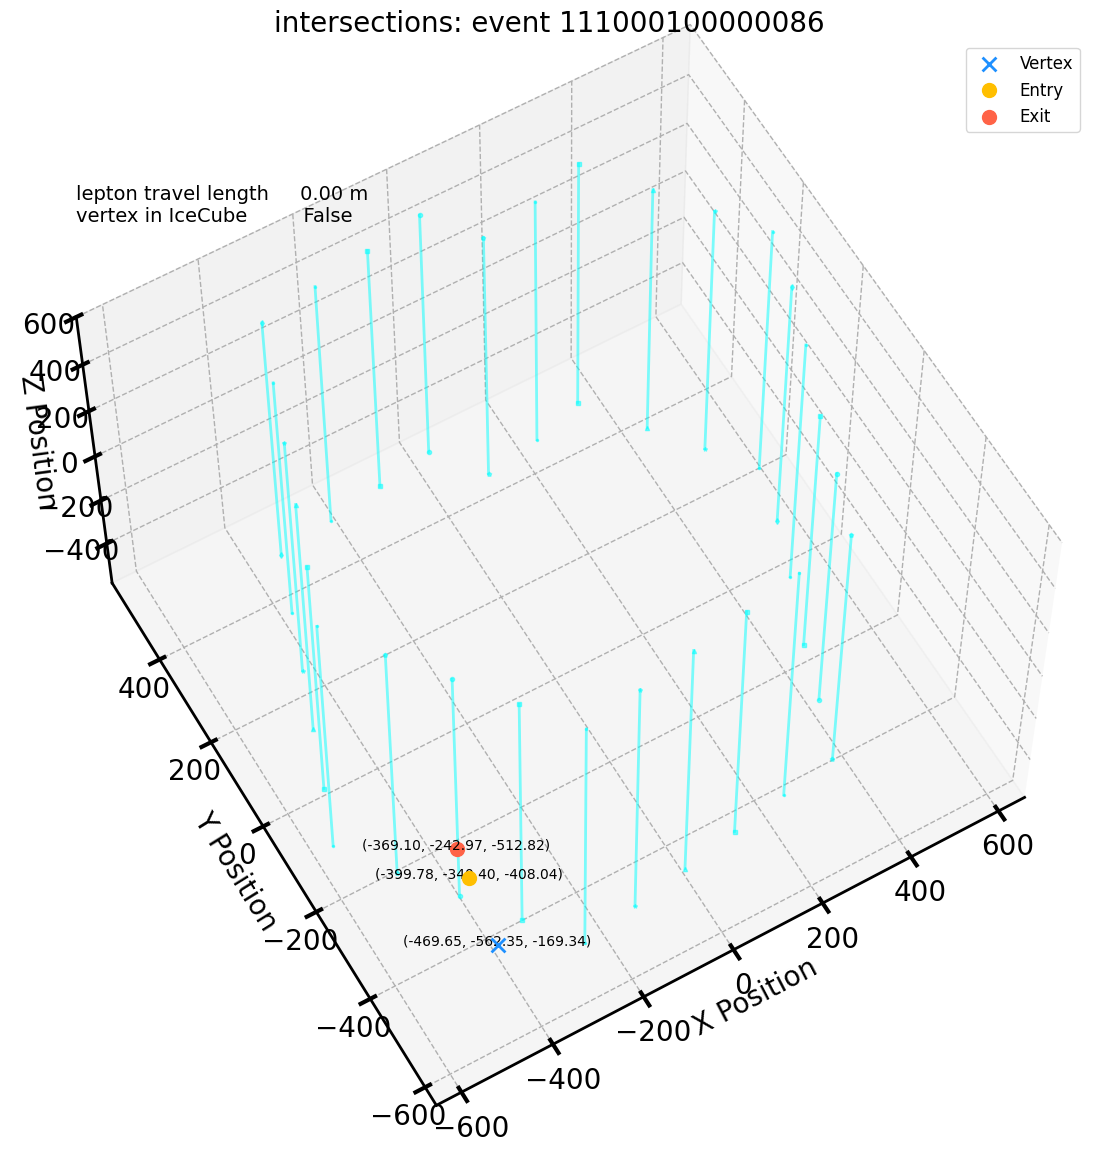

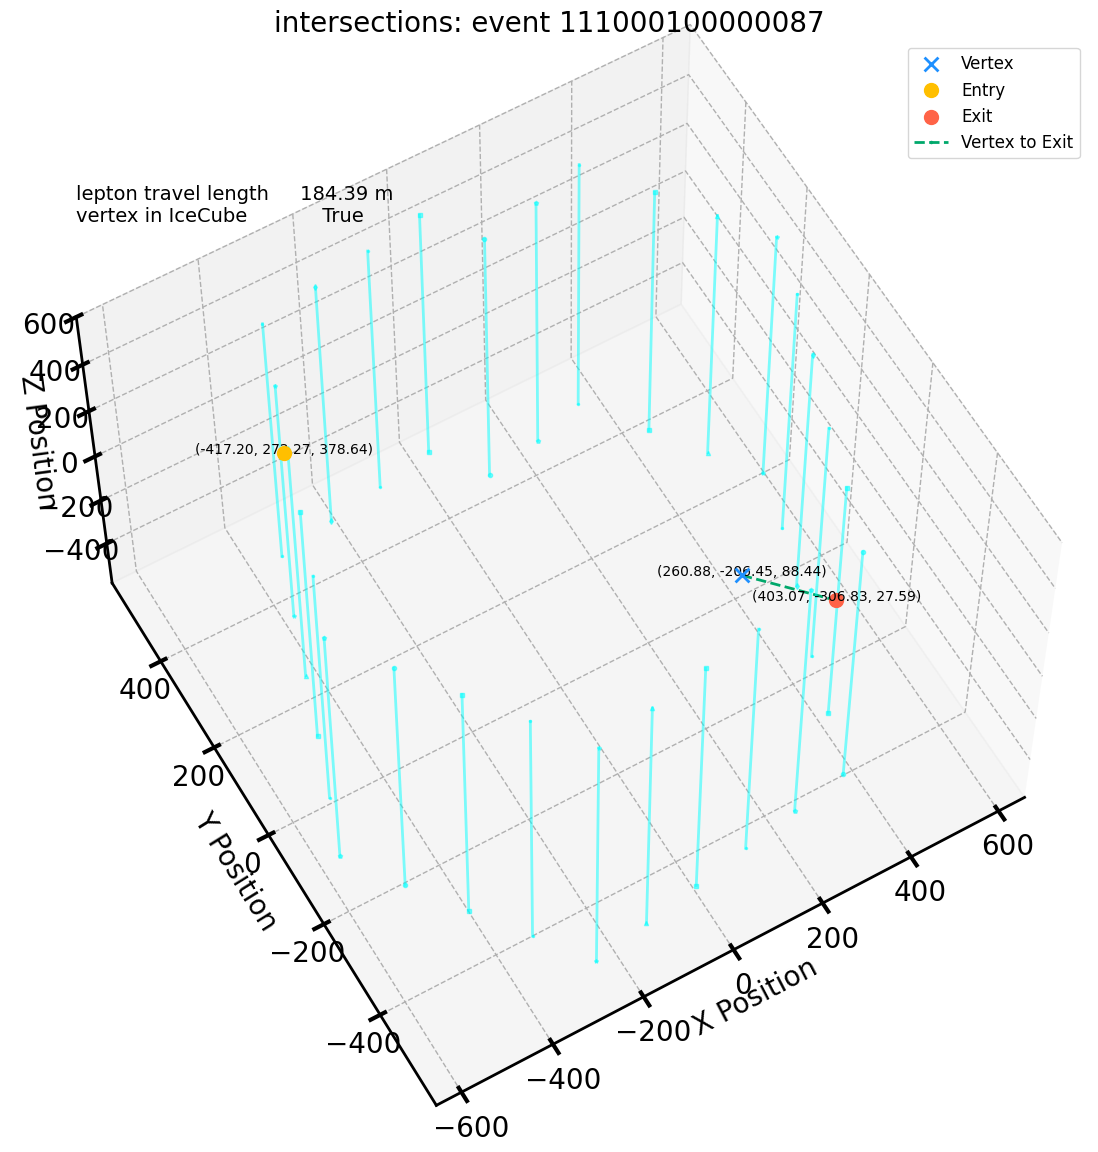

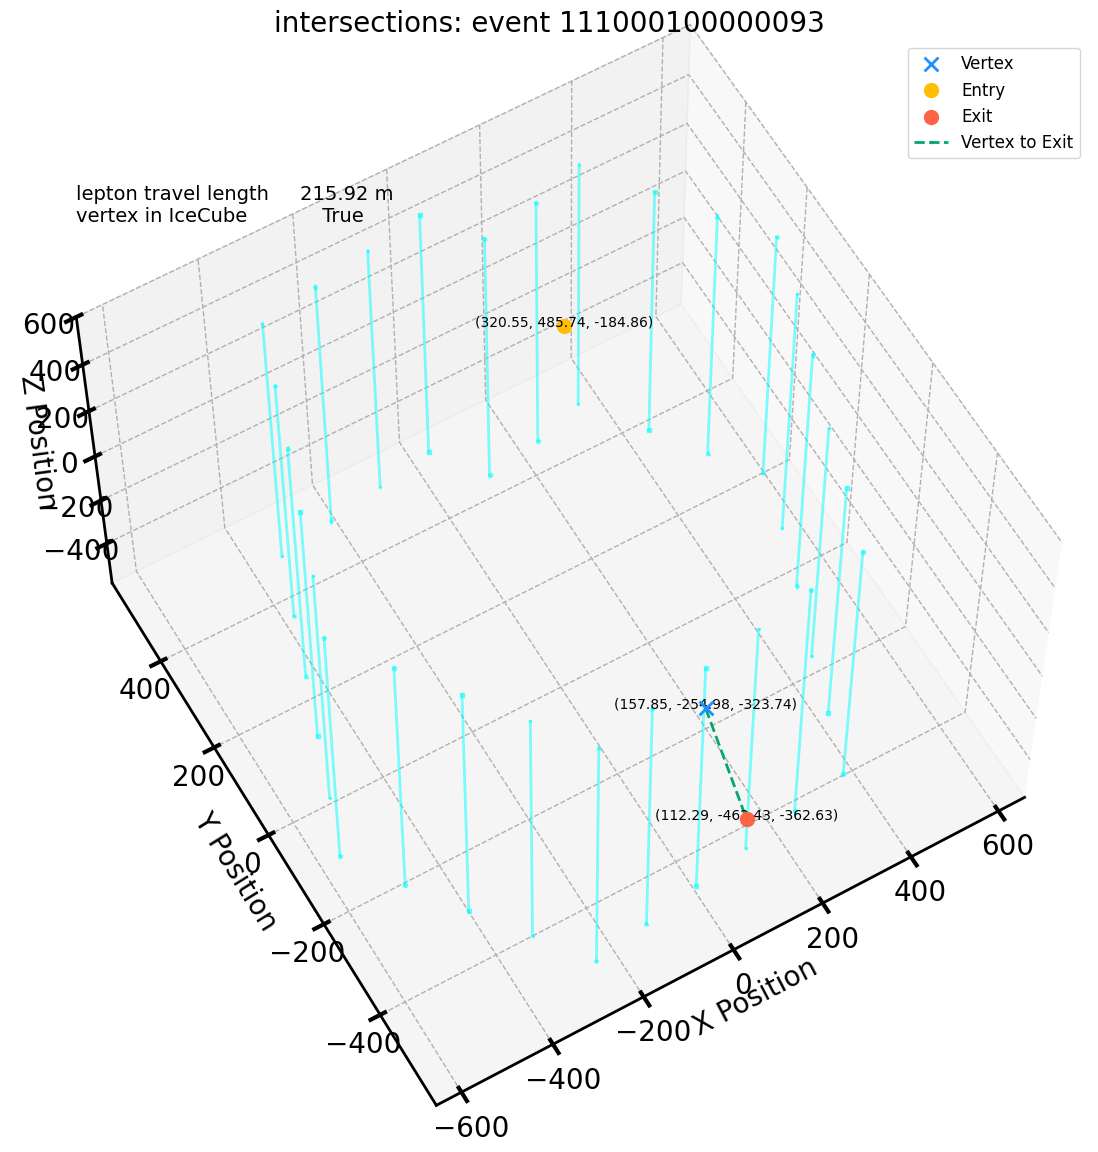

In [257]:
for _, row in df_reduced_added_two_intersections.iterrows():
    plot_intersections_and_vertex(row)
